### Note: At the bottom of the notebook section: "Worth exploring if time permits" 
- Are WIP extensions of whatever that is already done which may not be included in the final version, everything above it is final and can be used for Combined EDA especially pairplots, corr. plots, modelling, etc.     

-WJ

range for dates in train/test: 
start: 29-05-2007
end: 26-09-2013
frequency: weekly ( TS-Features should be adjusted to weekly to be able to used in Train/test)

- #Remove this block before submission

### Module Imports

In [3]:
# Standard imports
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)
from scipy.stats import pearsonr

# Time Series imports
import datetime as dt
import pytz
import suntime as st

# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt

# Please reduce "DPI" values below if plots take too long to display 
# Higher values make plots remain clear when zoomed in
plt.rcParams['figure.dpi'] = 300
# The lowest recommended value is 200 for A4 size print legibility 
# The recommended value is 600 for 'photograph-like' legibility
plt.style.use('seaborn-whitegrid')


# Geographical imports
import haversine as hs
from haversine import Unit

# Note to self: Remember to check and 
# include version numbers for modules used before submission 
# (Remove this before submission)

### Function Definitions

In [4]:
# Plotting Functions
def subplot_hist(dataframe,list_of_columns, suptitle, list_of_titles,datafigsize):
    fig, ax = plt.subplots((len(list_of_columns)//2), 2,figsize= datafigsize) 
    fig.suptitle(suptitle,fontsize=30)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    plt.tight_layout(h_pad = 2,pad=5);
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column],color="lightblue") 
        ax[i].set_title(list_of_titles[i],fontdict={'fontsize': 15})
        ax[i].xaxis.set_visible(True)
        ax[i].axvline(dataframe[column].mean(), color='r', linestyle='dashed', linewidth=1,label='mean')
        ax[i].axvline(dataframe[column].median(), color='b', linestyle='dashed', linewidth=1,label="median")
        ax[i].legend(loc='upper right');

def subplot_line(values):
    pd.pivot_table(weather.reset_index(),index='Month', columns='Year', values=values).plot(subplots=True, 
    sharey = True, sharex = True, figsize = (7,35), ylabel = values, xlabel = 'Month');
    
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

In [5]:
# String mapper 
def m_t_mapper(df,columns):
    for i in columns:
        df[i] = df[i].apply(lambda x: np.nan if x =='M' else x)# replace values with 'M' as np.nan
        df[i] = df[i].apply(lambda x: 0 if x =='  T' else x) # replace values with 'T' as 0     
        df[i] = df[i].astype('float') # Convert dataype of index as float
        
# Median imputer
def median_imputer(df,columns):
    for i in columns:
        df[i].fillna(df[i].median(), inplace = True)
        # replace np.nan values with median value of column
        
# Mean imputer
def mean_imputer(df,columns):
    for i in columns:
        df[i].fillna(df[i].mean(), inplace = True)
        # replace np.nan values with mean value of column

# Time lag column creator
def timelag_col_creator(df, columns, timelag_range):
    for col in columns:
        for num in range(1,timelag_range+1):
            df[col+'_lag'+str(num)] = df[col].shift(num)
            
# Rolling mean column creator
def rollmean_col_creator(df, columns, window_num):
    for col in columns:
        df['Weekly_'+col] = df[col].rolling(window=window_num).mean()

### Read CSVs

In [9]:
weather = pd.read_csv('../Data/weather.csv')

In [10]:
# CSV link above will likely break, as file will be stored in data folder and not together with pynb

The `weather.csv` file also came with documentation to explain the columns and its values to laypersons. We have attached the document [here](../files/weather_csv_readme.pdf) for ease of reference.

In [11]:
# Document link above will likely break, as file was renamed from original

Here are some information on each of the stations, from [Kaggle](https://www.kaggle.com/competitions/predict-west-nile-virus/data)
- **Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT**
    - Lat: 41.995 
    - Lon: -87.933 
    - Elev: 662 ft. above sea level  

- **Station 2: CHICAGO MIDWAY INTL ARPT**
    - Lat: 41.786 
    - Lon: -87.752 
    - Elev: 612 ft. above sea level

In [12]:
weather.shape

(2944, 22)

In [13]:
# checking for duplicated rows
weather.duplicated().sum()

0

In [14]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [15]:
# View first 5 rows in the dataframe
weather.head(5)
# click ... below to see output

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

  Sunrise Sunset CodeSum Depth Water1 SnowFall PrecipTotal StnPressure  \
0    0448   1849             0      M      0.0        0.00       29.10   
1       -      -             M      M        M        0.00       29.18   
2    0447   1850      BR     0      M      0.0        0.00       29.38   
3       -      -   BR HZ     M      M        M        0.00       29.44   
4    0446   1851             0      M      0.0        0.00       29.39   

  SeaLevel  ResultSpeed  ResultDir AvgSpeed  
0    29.82          1.7         27      9.2  
1    29.82          2.7         25      9.6  
2    30.09         13.0          4     13.4  
3    30.08         13.3          2     13.4  
4    30.12         11.7          7     11.9

In [16]:
# Calculating Haversine Distance between the two stations
stn1 = (41.995, -87.933)
stn2 = (41.786, -87.752)
dist_btw_stn1_stn2 = hs.haversine(stn1,stn2,unit=Unit.KILOMETERS)
print(f' The distance between Station 1 and 2 in kilometers is {round(dist_btw_stn1_stn2,2)}km.')

 The distance between Station 1 and 2 in kilometers is 27.65km.


In [17]:
# info shows us the datatypes for each columns, presence of null values as well as the column names
weather.info()
# click ... below to see output

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

### Data Cleaning

According to this part regarding column descriptions in "noaa_weather_qclcd_documentation", 

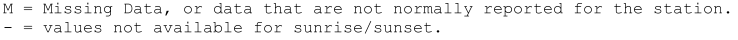

From our `weather.info()`, we also note that the 'Date' column is classified as object which is incorrect, let us deal with the 'Date' column first to prevent issues later on when we perform batch processing of the remaining 'object' columns. 


In [18]:
# Showing unique values for all columns
for col in weather.columns:
    print(f"{col}:")
    print(weather[col].unique())
    print('\n')
# Click ... below to see output

Station:
[1 2]


Date:
['2007-05-01' '2007-05-02' '2007-05-03' ... '2014-10-29' '2014-10-30'
 '2014-10-31']


Tmax:
[ 83  84  59  60  66  67  78  68  82  80  77  76  70  73  64  65  69  90
  62  61  71  79  87  89  88  75  85  86  81  72  63  91  92  93  74  94
  54  53  56  57  58  55  50  95  52  47  45  51  48  44  49  46  96  99
 100 101  97  98 102 103 104  42  41]


Tmin:
[50 52 42 43 46 48 49 51 53 54 47 60 61 63 56 59 44 57 45 55 66 65 70 68
 62 67 64 58 71 69 73 75 72 74 39 41 40 37 34 38 35 36 33 31 32 76 77 29
 78 79 80 81 82 83]


Tavg:
['67' '68' '51' '52' '56' '58' 'M' '60' '59' '65' '70' '69' '71' '61' '55'
 '57' '73' '72' '53' '62' '63' '74' '75' '78' '76' '77' '66' '80' '64'
 '81' '82' '79' '85' '84' '83' '50' '49' '46' '48' '45' '54' '47' '44'
 '40' '41' '38' '39' '42' '37' '43' '86' '87' '89' '92' '88' '91' '93'
 '94' '90' '36']


Depart:
['14' 'M' '-3' ' 2' ' 4' ' 5' '10' '12' '13' '-2' '15' '11' '-4' '-6' ' 8'
 '-5' ' 1' ' 9' ' 6' '-9' '-8' ' 3' ' 0' '-1' '-7' ' 7'

It also seems that we have quite a few columns which are not typed properly as a consequence of having "M" values causing them to be classfied as 'object' columns when the remaining values are numerical in nature.   
`Sunset` and `Sunrise` also have a `-` value, which seem to only come from data logged by Station 2.   
With reference to the earlier document, 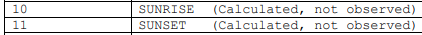
it seems that `Sunset` and `Sunrise` are [calculated](https://gml.noaa.gov/grad/solcalc/solareqns.PDF) instead of observed. Let's see if we are able to calculate the `Sunset` and `Sunrise` times with the help of external libraries and use the calculated values for imputation. 

In [19]:
# Converting dtype of 'Date' column to 'datetime'
weather['Date'] = pd.to_datetime(weather['Date'],format='%Y-%m-%d %H:%M')

In [20]:
# Initializing Sun object with lat. long. values of station 2
s = st.Sun(stn2[0],stn2[1])
# Storing UTC as our timezone
utc = pytz.timezone('US/Central')

# Initializing empty lists to store sunrise/sunset times for given dates
sunrise_list = []
sunset_list = []
for value in weather['Date']:
    abd = value
    abd_sr = s.get_local_sunrise_time(value, local_time_zone=utc)
    abd_sr = abd_sr - abd_sr.dst()
    abd_ss = s.get_local_sunset_time(value, local_time_zone=utc)
    abd_ss = abd_ss - abd_ss.dst()
    sunrise_list.append(abd_sr.strftime('%H%M'))
    sunset_list.append(abd_ss.strftime('%H%M'))

# Impute values
index = weather.loc[weather['Station']==2].index
for i in index:
    weather.loc[i, 'Sunrise'] = sunrise_list[i]
    weather.loc[i, 'Sunset'] = sunset_list[i]

As such, while `weather.info()` might not show any missing data at first glance, we need to look closer at the columns which contains "M" values as they are actually missing data. To facilitate processing, we will map these "M" values as `np.nan`. On top of that M also denotes data not recorded at a particular station.

In [21]:
cols_to_fill = ['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Depth','Water1', 'SnowFall','PrecipTotal','StnPressure','SeaLevel','AvgSpeed']
m_t_mapper(weather,cols_to_fill)

In [22]:
cols_to_flt = ['Tmax','Tmin','DewPoint','ResultDir']
for col in cols_to_flt:
    weather[col].astype('float')

In [23]:
# Descriptive statistics for numerical columns in weather df
weather.describe().T
# click ... below to see output

count       mean        std    min    25%    50%    75%     max
Station      2944.0   1.500000   0.500085   1.00   1.00   1.50   2.00    2.00
Tmax         2944.0  76.166101  11.461970  41.00  69.00  78.00  85.00  104.00
Tmin         2944.0  57.810462  10.381939  29.00  50.00  59.00  66.00   83.00
Tavg         2933.0  67.240027  10.545442  36.00  60.00  69.00  75.00   94.00
Depart       1472.0   1.954484   6.841110 -17.00  -3.00   2.00   7.00   23.00
DewPoint     2944.0  53.457880  10.675181  22.00  46.00  54.00  62.00   75.00
WetBulb      2940.0  59.310884   9.286742  32.00  53.00  61.00  67.00   78.00
Heat         2933.0   3.407092   5.953203   0.00   0.00   0.00   5.00   29.00
Cool         2933.0   5.647119   6.105087   0.00   0.00   4.00  10.00   29.00
Depth        1472.0   0.000000   0.000000   0.00   0.00   0.00   0.00    0.00
Water1          0.0        NaN        NaN    NaN    NaN    NaN    NaN     NaN
SnowFall     1472.0   0.000068   0.002606   0.00   0.00   0.00   0.00    0.10
PrecipTotal  2942.0   0.131329   0.393327   0.00   0.00   0.00   0.06    6.86
StnPressure  2940.0  29.284429   0.158543  28.55  29.19  29.28  29.39   29.86
SeaLevel     2935.0  29.968129   0.158597  29.23  29.87  29.97  30.06   30.53
ResultSpeed  2944.0   6.960666   3.587527   0.10   4.30   6.40   9.20   24.10
ResultDir    2944.0  17.494905  10.063609   1.00   7.00  19.00  25.00   36.00
AvgSpeed     2941.0   8.580449   3.147300   1.70   6.30   8.10  10.40   26.30

In [24]:
# Save the columns with null values count/ as percentage of rows in dataframe
mv_cols_count = weather.isnull().sum().sort_values(ascending=False)
mv_cols_percent = weather.isnull().sum().sort_values(ascending=False)/len(weather) * 100
# Filtering out cols with no missing values
mv_cols_count = mv_cols_count[mv_cols_count.values > 0]
mv_cols_percent = mv_cols_percent[mv_cols_percent.values > 0]

In [25]:
# Concatenating both columns for missing values and missing values in % of length of dataframe
pd.concat([mv_cols_count, mv_cols_percent], axis=1, keys=['Total', 'Percentage'])
# Click ... below to see output

Total  Percentage
Water1        2944  100.000000
Depart        1472   50.000000
SnowFall      1472   50.000000
Depth         1472   50.000000
Tavg            11    0.373641
Cool            11    0.373641
Heat            11    0.373641
SeaLevel         9    0.305707
StnPressure      4    0.135870
WetBulb          4    0.135870
AvgSpeed         3    0.101902
PrecipTotal      2    0.067935

#### Observations
At a glance, we can group these columns into 2 broad categories, columns with missing values which constitute 50% or higher of all the rows, and columns which constitute less than 5% of all the rows in the dataset.  

The following columns will be dropped, along with the reasons for dropping them:  

**Water1**: 100% missing values, no valuable information which can be derived   
**Depature**: While having some degree of variability, too many missing values are present (50% missing values)  
**SnowFall**: 50% missing values, too little variation between values  
(0.0, 0.1, 'T', 'nan') where T denotes trace values too minimal to be registered.  
**Depth**: 50% missing values, no variation between values (0, 'nan')



In [26]:
# Drop columns
weather.drop(columns=['Water1', 'SnowFall', 'Depth','Depart'], inplace=True)

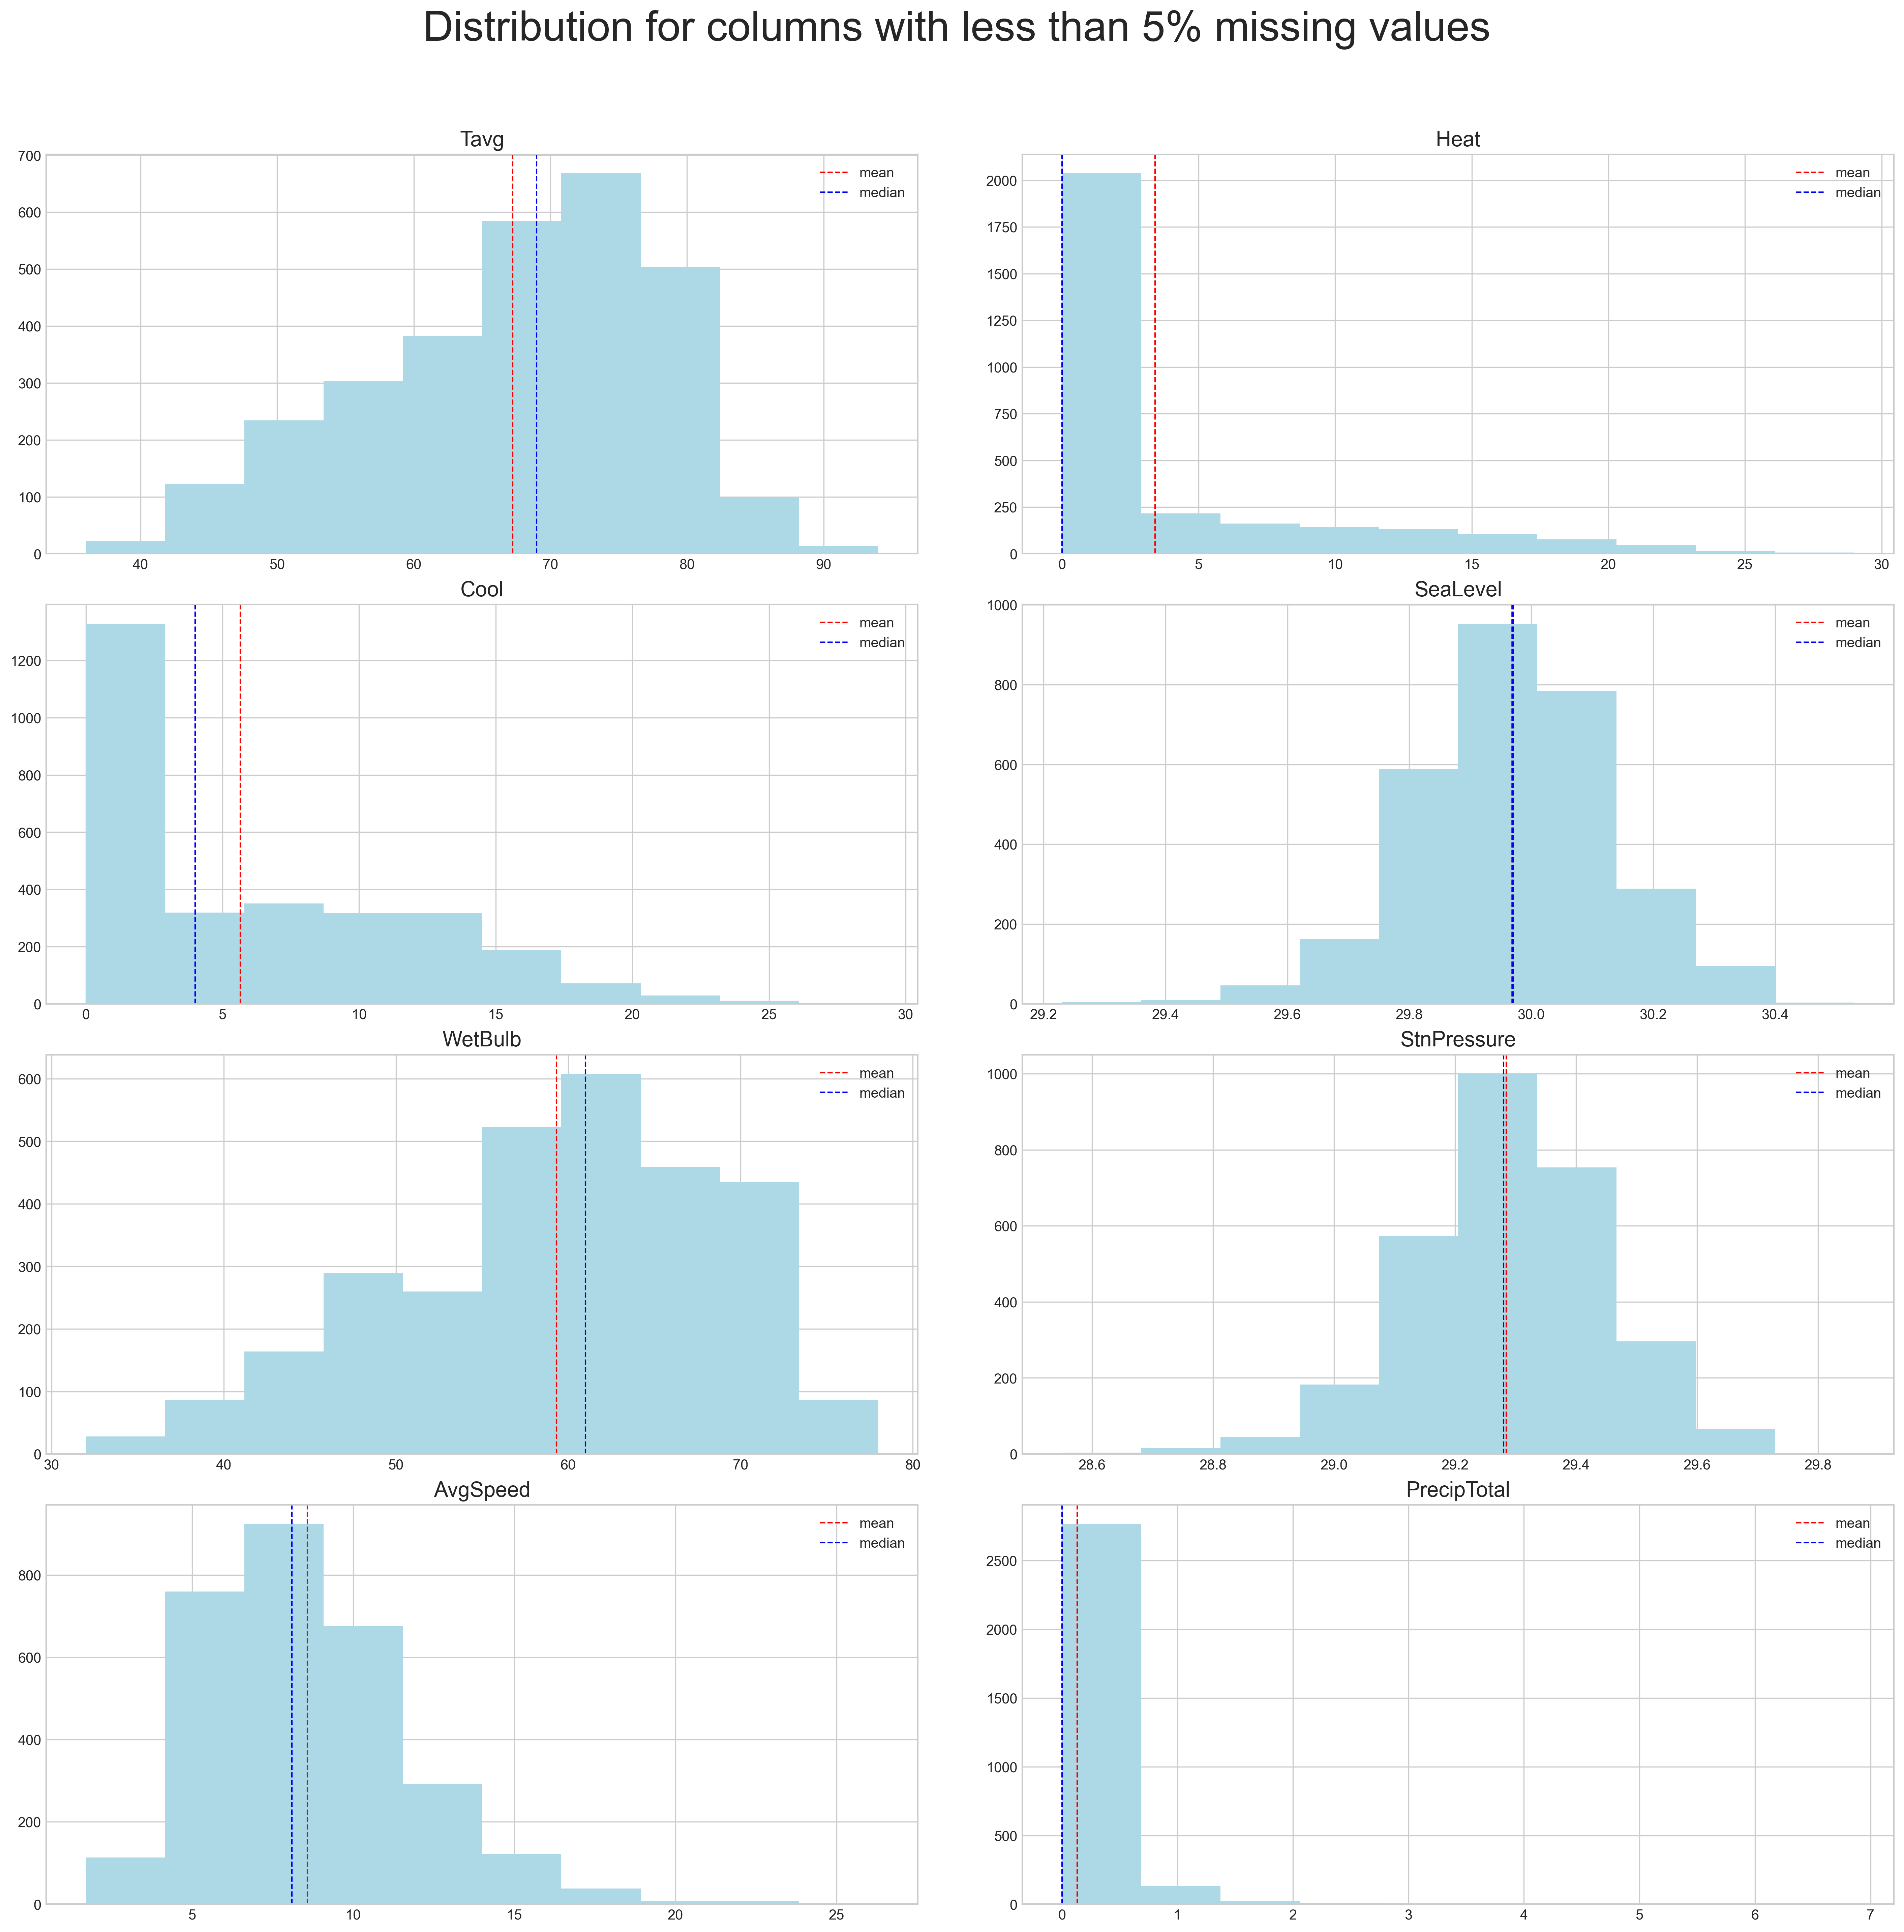

In [27]:
# Visualizing columns with less than 5% missing values
col_lessthan5 = ['Tavg', 'Heat', 'Cool','SeaLevel','WetBulb','StnPressure','AvgSpeed','PrecipTotal']  
subplot_hist(weather,col_lessthan5,"Distribution for columns with less than 5% missing values ", col_lessthan5,(20,20))

In [28]:
# Prints Median and Mean values for columns with less than 5% of all rows in the dataset as missing values
for i in col_lessthan5:
    print(i)
    print('Median:', weather[i].median(),'Mean:', round(weather[i].mean(),3))
    # Click ... below to see output

Tavg
Median: 69.0 Mean: 67.24
Heat
Median: 0.0 Mean: 3.407
Cool
Median: 4.0 Mean: 5.647
SeaLevel
Median: 29.97 Mean: 29.968
WetBulb
Median: 61.0 Mean: 59.311
StnPressure
Median: 29.28 Mean: 29.284
AvgSpeed
Median: 8.1 Mean: 8.58
PrecipTotal
Median: 0.0 Mean: 0.131


Looking at the visualizations as well as the median and mean values, we observe the following distributions for these columns:   

**Negatively skewed distribution (Median > Mean):**
- Tavg
- Wetbulb

**Positively skewed distribution (Mean > Median):**
- Heat
- Cool
- AvgSpeed
- PrecipTotal

**Normal Distribution (Median ~ Mean, when rounded to 1 decimal place):**
- SeaLevel
- StnPressure

Based on these observations, columns with both positive and negatively skewed distributions will have their `np.nan` values imputed with their respective medians. Columns with normal distribution will have their `np.nan` values imputed with their respective means. 

The actual value of **'Tavg'** can be calculated by a such: **Tmax -Tmin / 2** which would provide more accurate values than using median.

In [29]:
# Imputing respective mean/median values for previously identified column distributions
median_impt_cols = ['WetBulb','Cool','Heat','AvgSpeed','PrecipTotal']
mean_impt_cols = ['SeaLevel','StnPressure']
median_imputer(weather, median_impt_cols)
mean_imputer(weather, mean_impt_cols)

In [30]:
# Imputing 'Tavg' using above mentioned formula,
weather['Tavg'] = weather['Tmax']-((weather['Tmax'] - weather['Tmin'])/2)
# Uncomment and run to check np.nan values after imputation
# weather.isnull().sum()

### EDA

As we converted our `weather['Date']` into `datetime` format earlier, we can use the `Datetime` libraries to extract the information into the various columns below.

In [31]:
# Creating Year, month Variable from Date
weather['Year'] = weather['Date'].dt.year 
weather['Month'] = weather['Date'].dt.month
weather['WeekofYear'] = weather['Date'].dt.isocalendar().week

With these columns created, we can now see relationships of our numerical columns over time more easily.

### Tavg

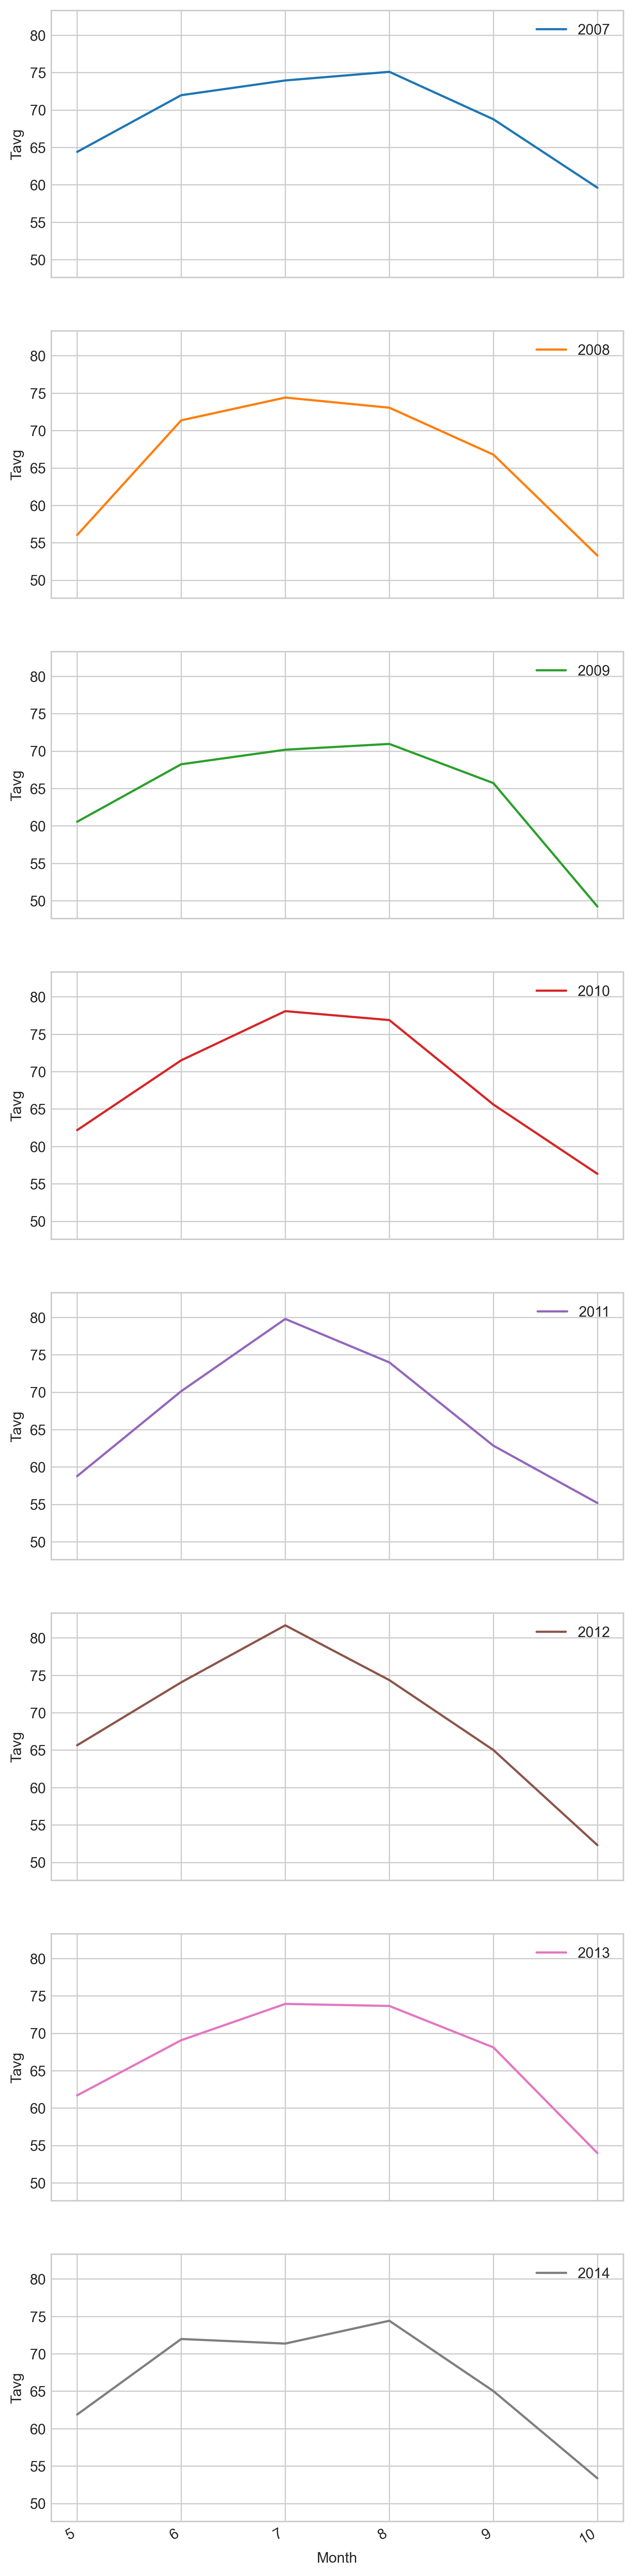

In [32]:
# Line plot visualization for mean Tavg values in each month for a given year
subplot_line('Tavg')

#### Observations
There seems to be a pattern where Tavg values are highest, usually either in the month of July or August:   
- **July** in years *2008, 2010, 2011, 2012* 
- **August** in years *2007, 2009, 2013, 2014*

### DewPoint

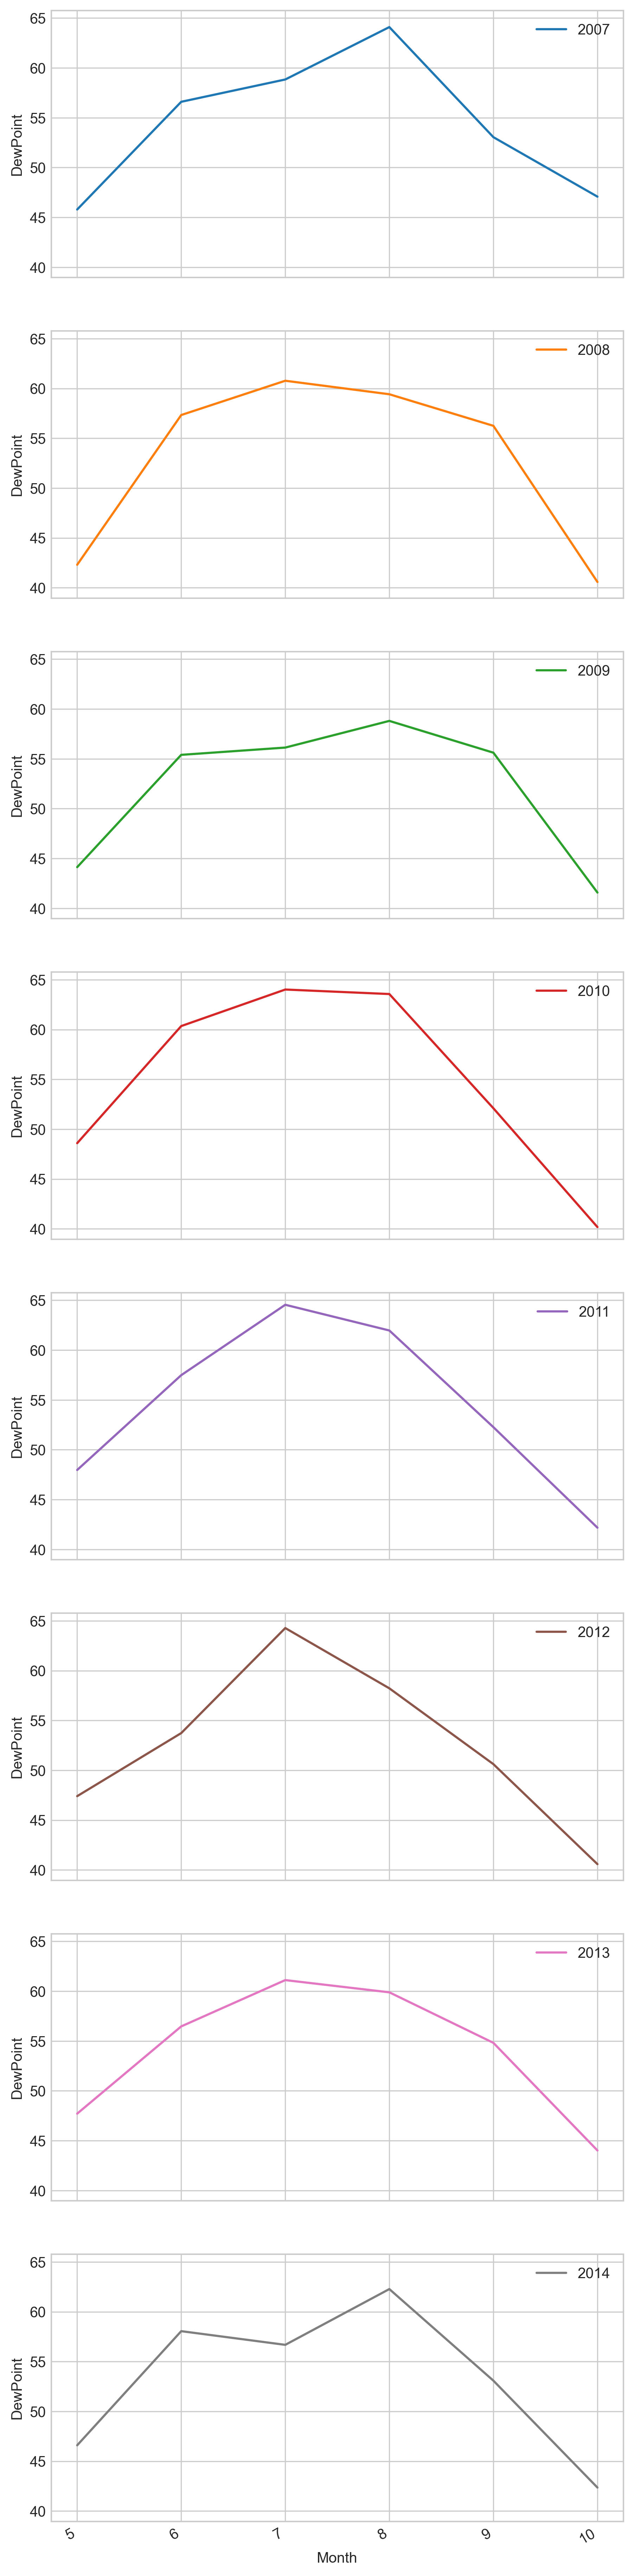

In [33]:
# Line plot visualization for mean DewPoint values in each month for a given year
subplot_line('DewPoint')

#### Observations
There seems to be a pattern where DewPoint values are highest, usually either in the month of July or August:   
- **July** in years *2008, 2010, 2011, 2012, 2013* 
- **August** in years *2007, 2009, 2014*

Comparing against what we see with `Tavg`, there seems to be some correlation between the two where highest values for both columns tend to fall between July and August.

### WetBulb

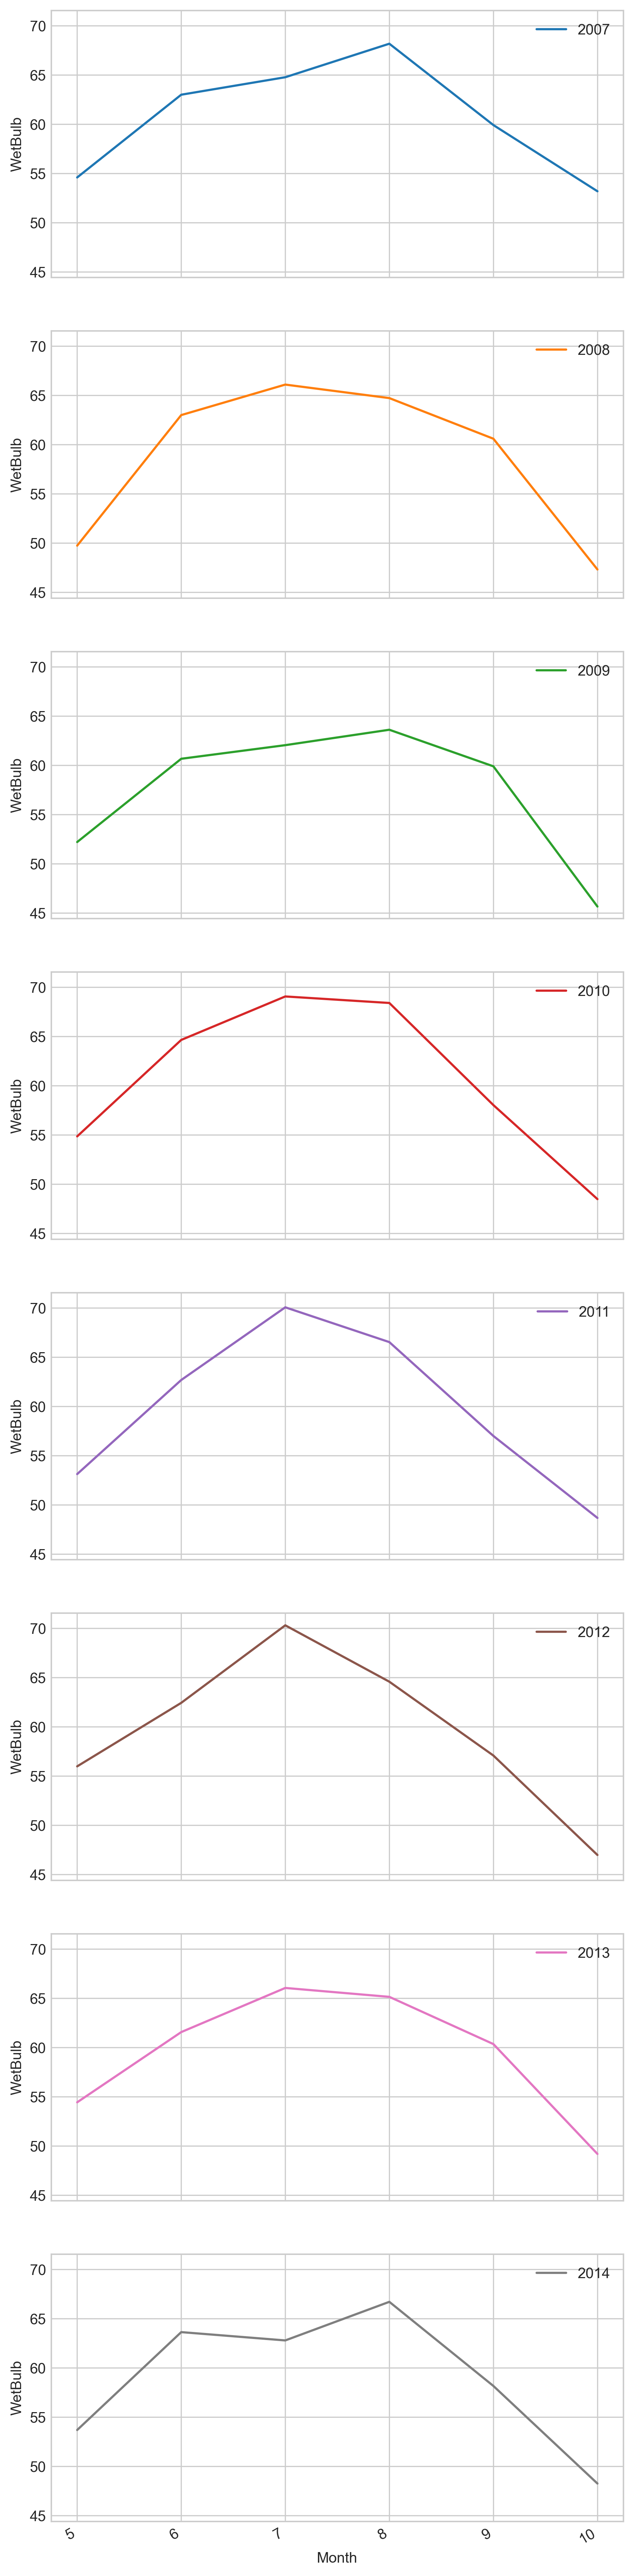

In [34]:
# Line plot visualization for mean WetBulb values in each month for a given year
subplot_line('WetBulb')

### Heat and Cool

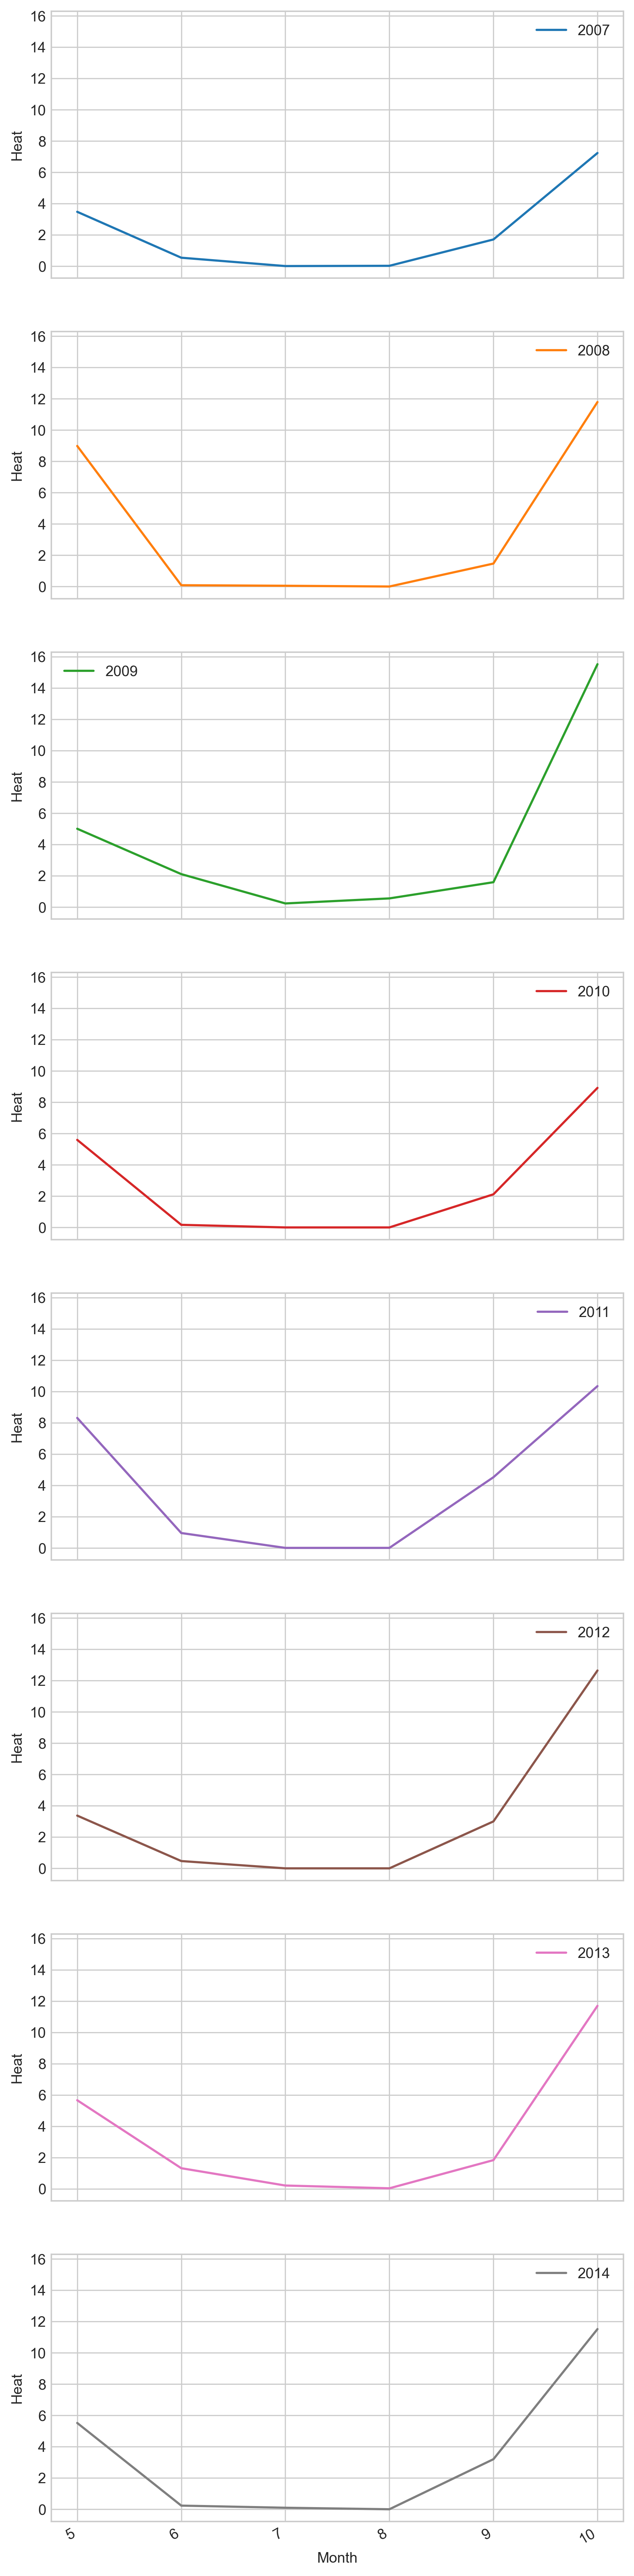

In [35]:
# Line plot visualization for mean Heat values in each month for a given year
subplot_line('Heat')

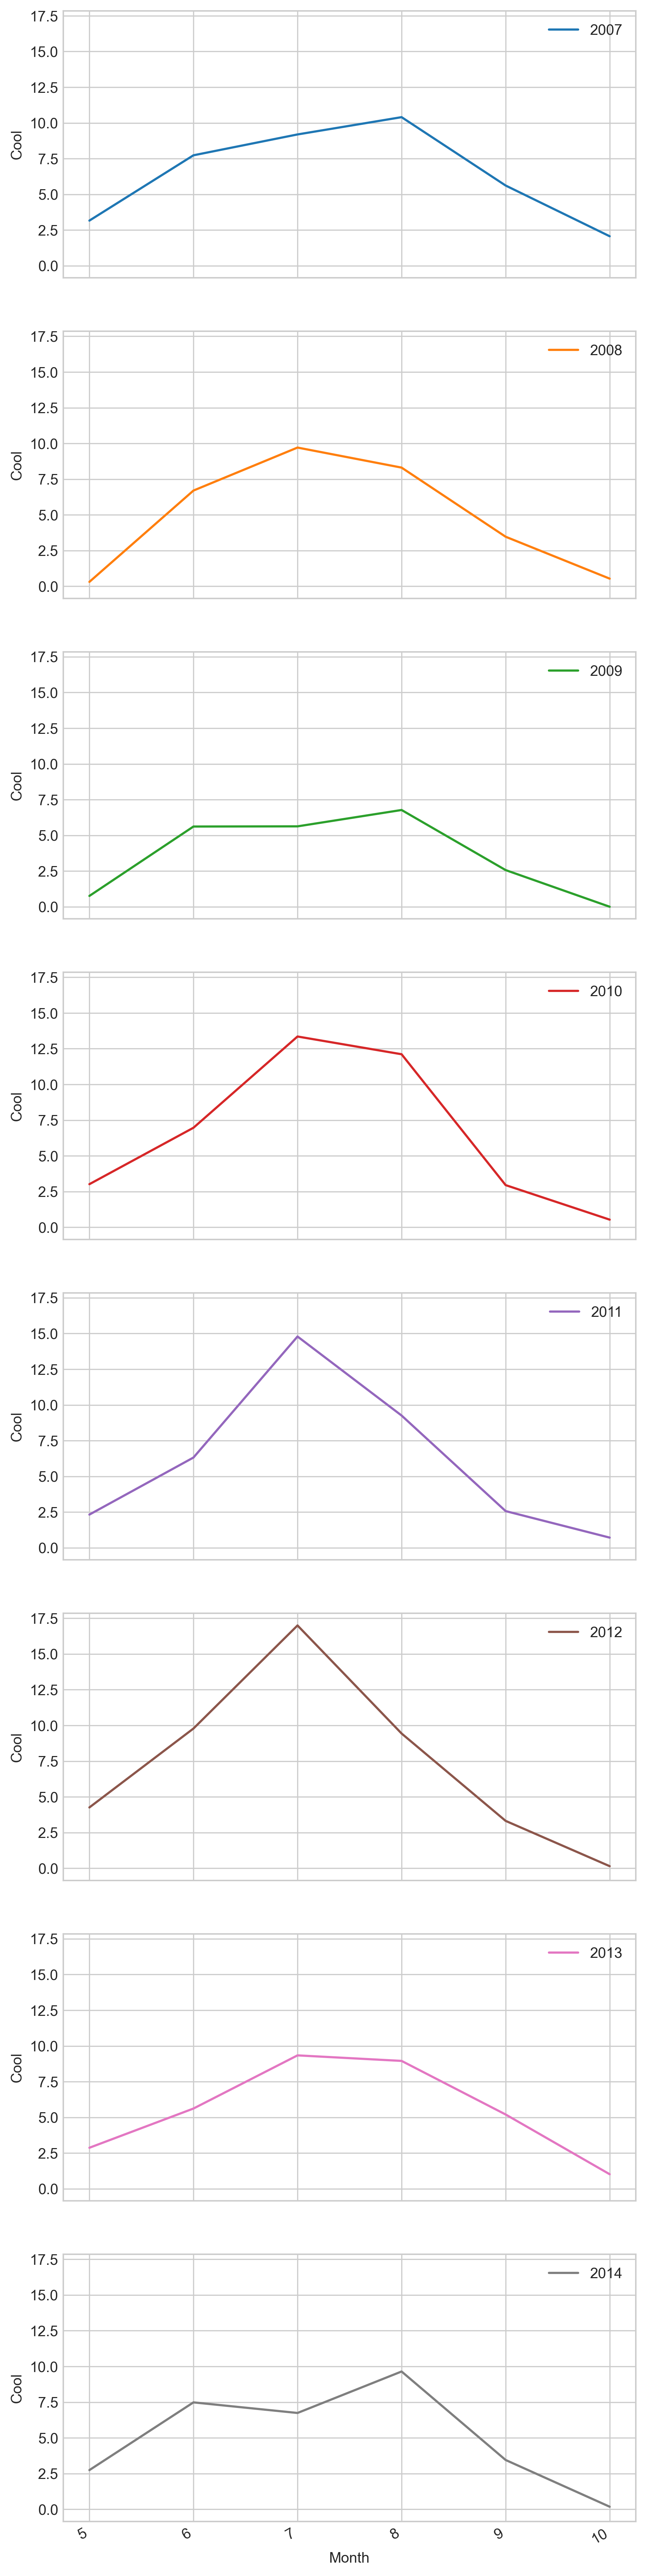

In [36]:
# Line plot visualization for mean Cool values in each month for a given year
subplot_line('Cool')

#### Observations
According to the earlier attached [document](../files/weather_csv_readme.pdf) detailing the descriptions for the columns. `Heat` and `Cool` seem to relate to the season in a given year.

- `Heat`: HEATING (SEASON BEGINS WITH JULY)  
- `Cool`: COOLING (SEASON BEGINS WITH JANUARY) 

- The values for relationships both these columns seem to align with that of `Tavg`, which once again may indicate high collinearity. We may want to drop both of these columns as `Tavg` is able to represent that relationship for both columns.

### PrecipTotal

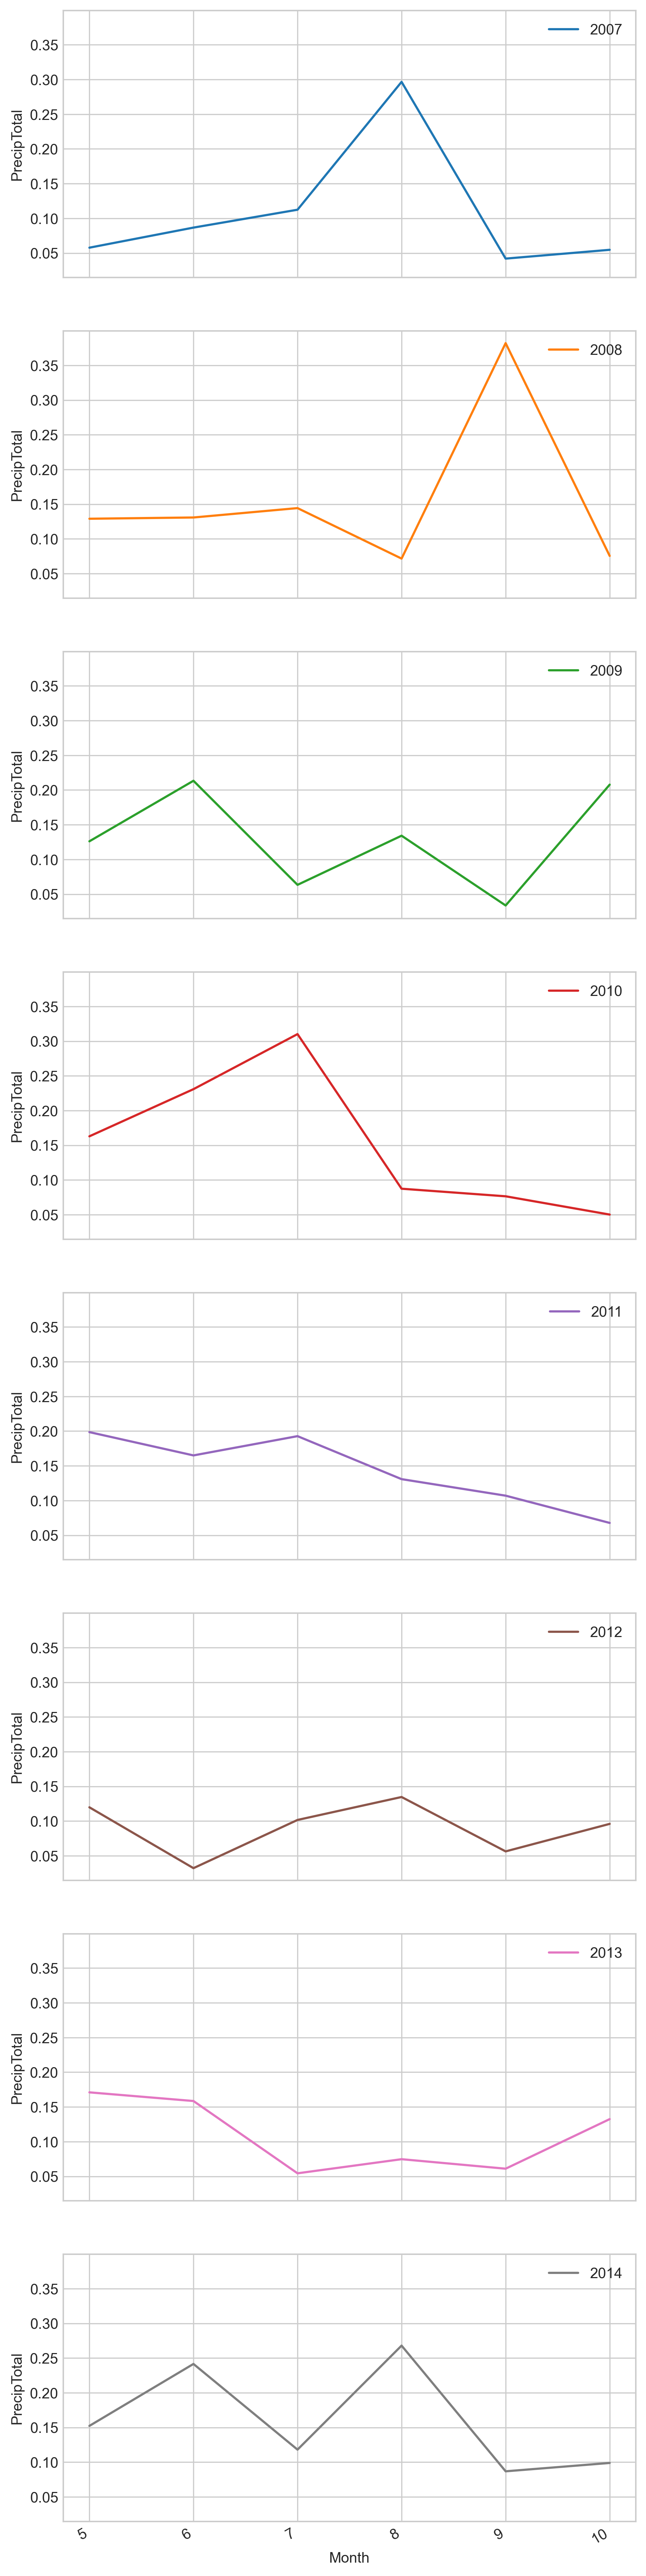

In [37]:
# Line plot visualization for mean PrecipTotal values in each month for a given year
subplot_line('PrecipTotal')

#### Observations
- PrecipTotal highest values usually vary between the months of July or August  every year, with the exception of years 2008 (September), 2009 (June), 2010/2013 (May)

- There does not seem to be any repeated patterns where the highest 'PrecipTotal' values consistently fall on the same months for 3 consecutive years.

### StnPressure

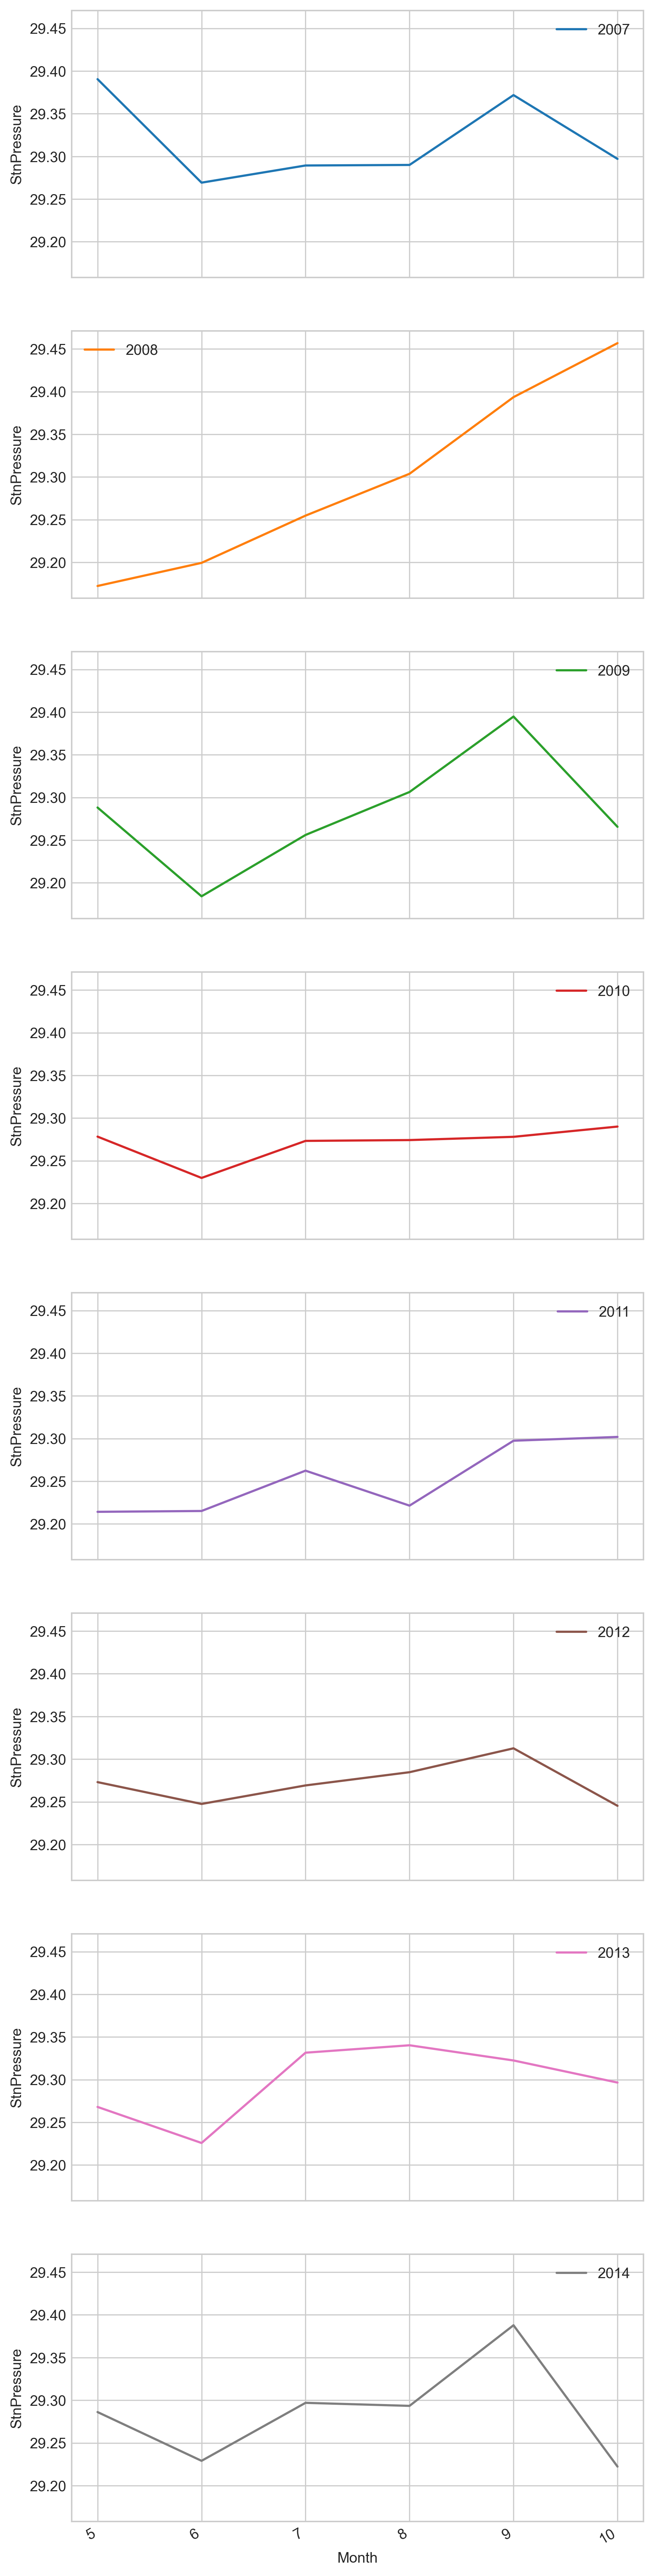

In [38]:
# Line plot visualization for mean StnPressure values in each month for a given year
subplot_line('StnPressure')

#### Observations
- With the exception of year 2007, it seems that `StnPressure` values tend to be higher in the later months as compared to earlier months.

- A closer at the fluctuations of the values is within a range of 0.3 INCHES OF HG , which may have too little variability to provide us with useful information.

### SeaLevel

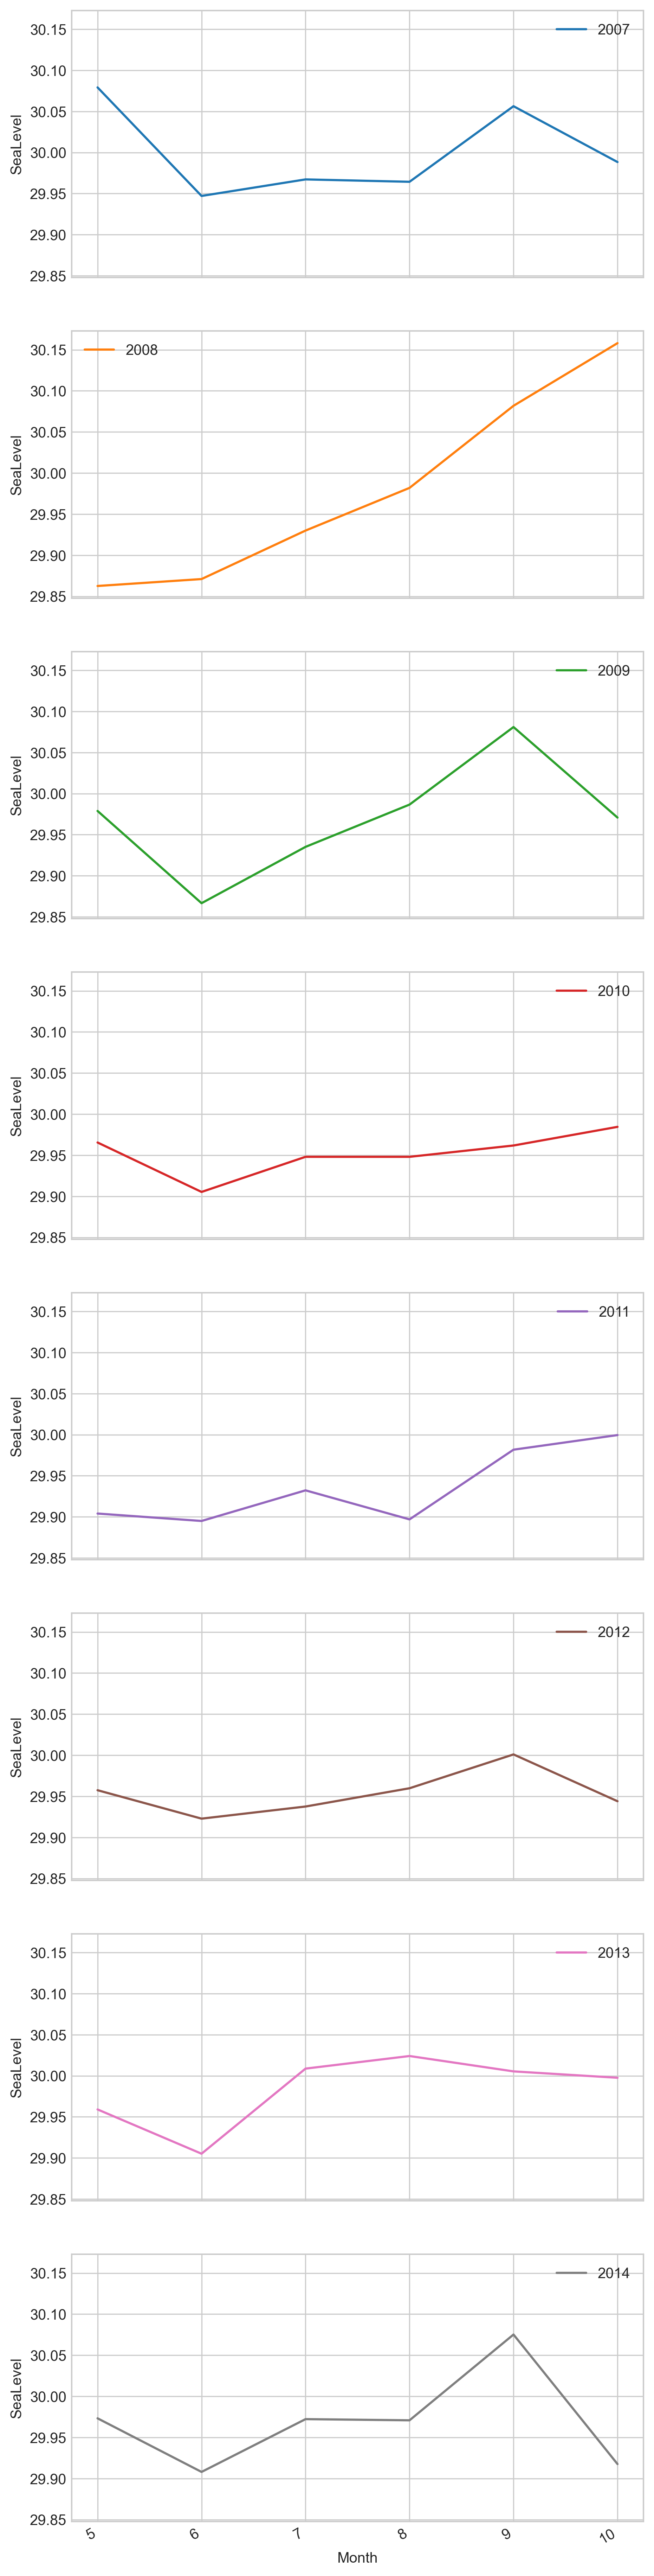

In [39]:
# Line plot visualization for mean SeaLevel values in each month for a given year
subplot_line('SeaLevel')

#### Observations
- `SeaLevel` values tell's us a similar story to that of `StnPressure`, suggesting that the two may be collinear with one another.


- A closer at the fluctuations of the values is within a range of 0.4 inches, which may have too little variability to provide us with useful information.

### AvgSpeed

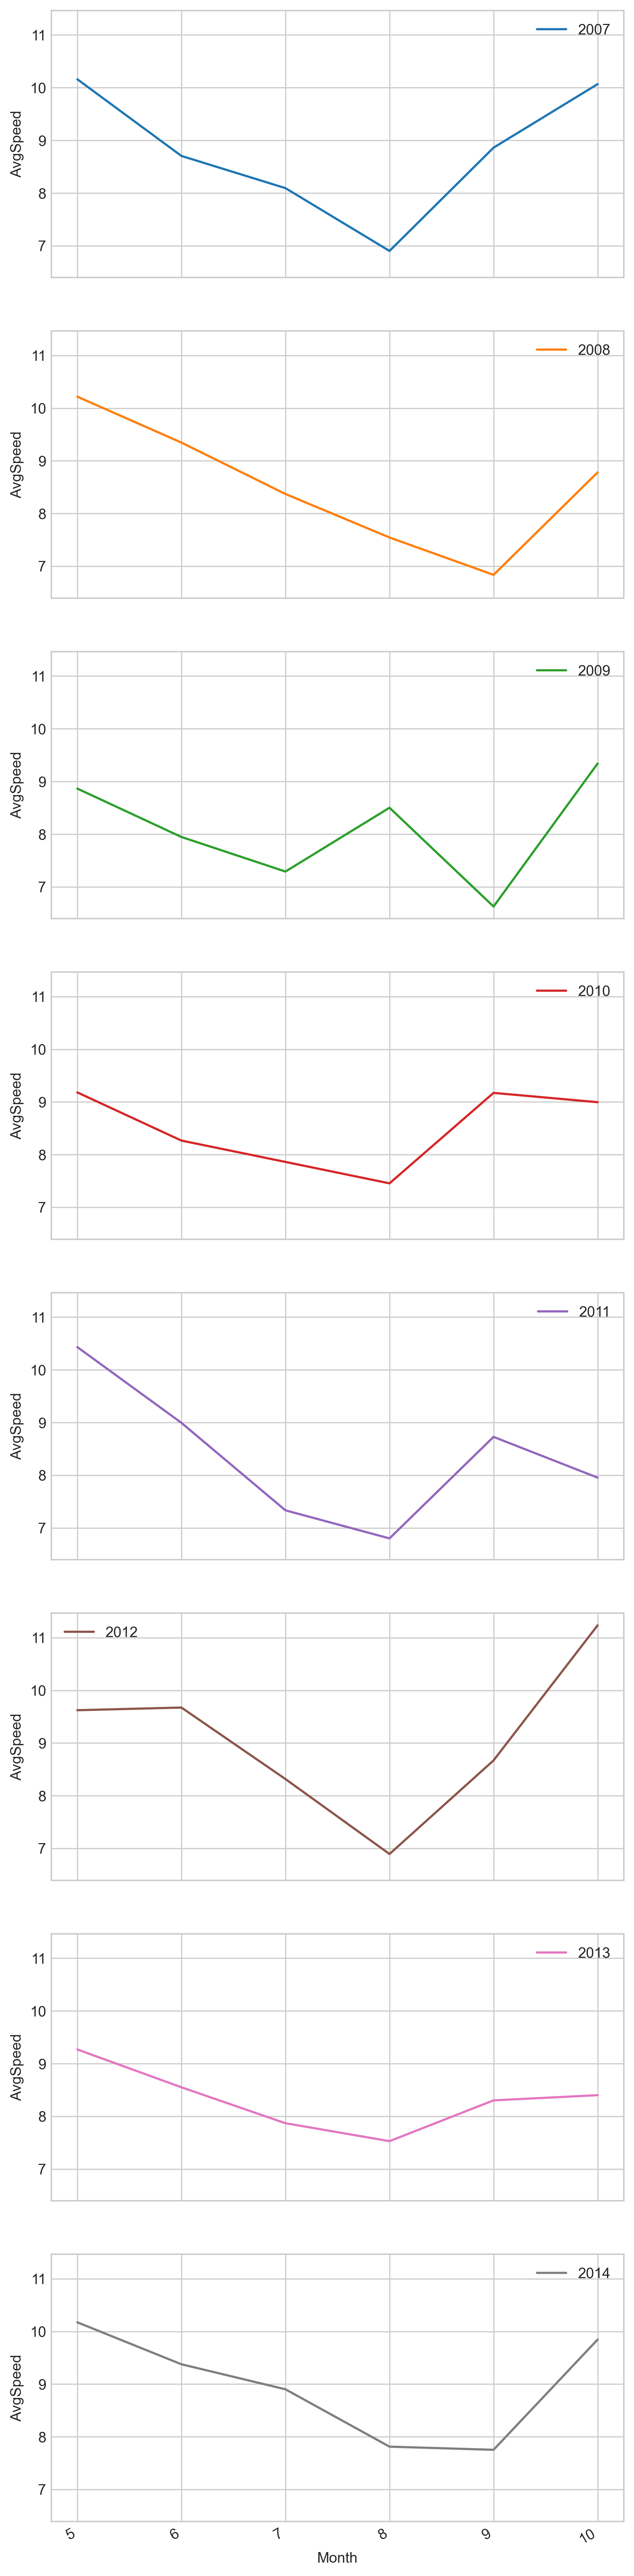

In [40]:
# Line plot visualization for mean AvgSpeed values in each month for a given year
subplot_line('AvgSpeed')

#### Observations
- Months which `AvgSpeed` lower values fall under (July - September) seem to corresponds with months which `Tavg`, `WetBulb` and `Dewpoint` higher values fall under, suggesting an inverse relationship.


### Daylight_Hours

With the `Sunset` and `Sunrise` columns for station 2 imputed using our calculated values, we engineer a feature named `Daylight_Hours` to more intuitively approximate mosquito behaviour, specifically feeding. 
  
With reference to the [literature](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3904402/), blood feeding by free-living insect vectors of disease is rhythmic and can be used to predict when infectious bites will occur. 

In [41]:
# Convert sunrise_ time values to datetime
sunrise_time = []
for val in weather['Sunrise']:
    date_val = dt.datetime.strptime(val, '%H%M')
    sunrise_time.append(date_val.hour + date_val.minute/60)
    
sunset_time = []
for val in weather['Sunset']:
    try:
        date_val = dt.datetime.strptime(val, '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)
    except:
        date_val = dt.datetime.strptime(val.replace('60', '59'), '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)
        
# Transform values to hours from midnight
weather['Sunrise'] = sunrise_time
weather['Sunset'] = sunset_time

In [42]:
# Create new feature for sun hours
weather['Daylight_Hours'] = weather['Sunset'] - weather['Sunrise']

Lets take a look at the distribution of the newly created `Daylight_Hours`,

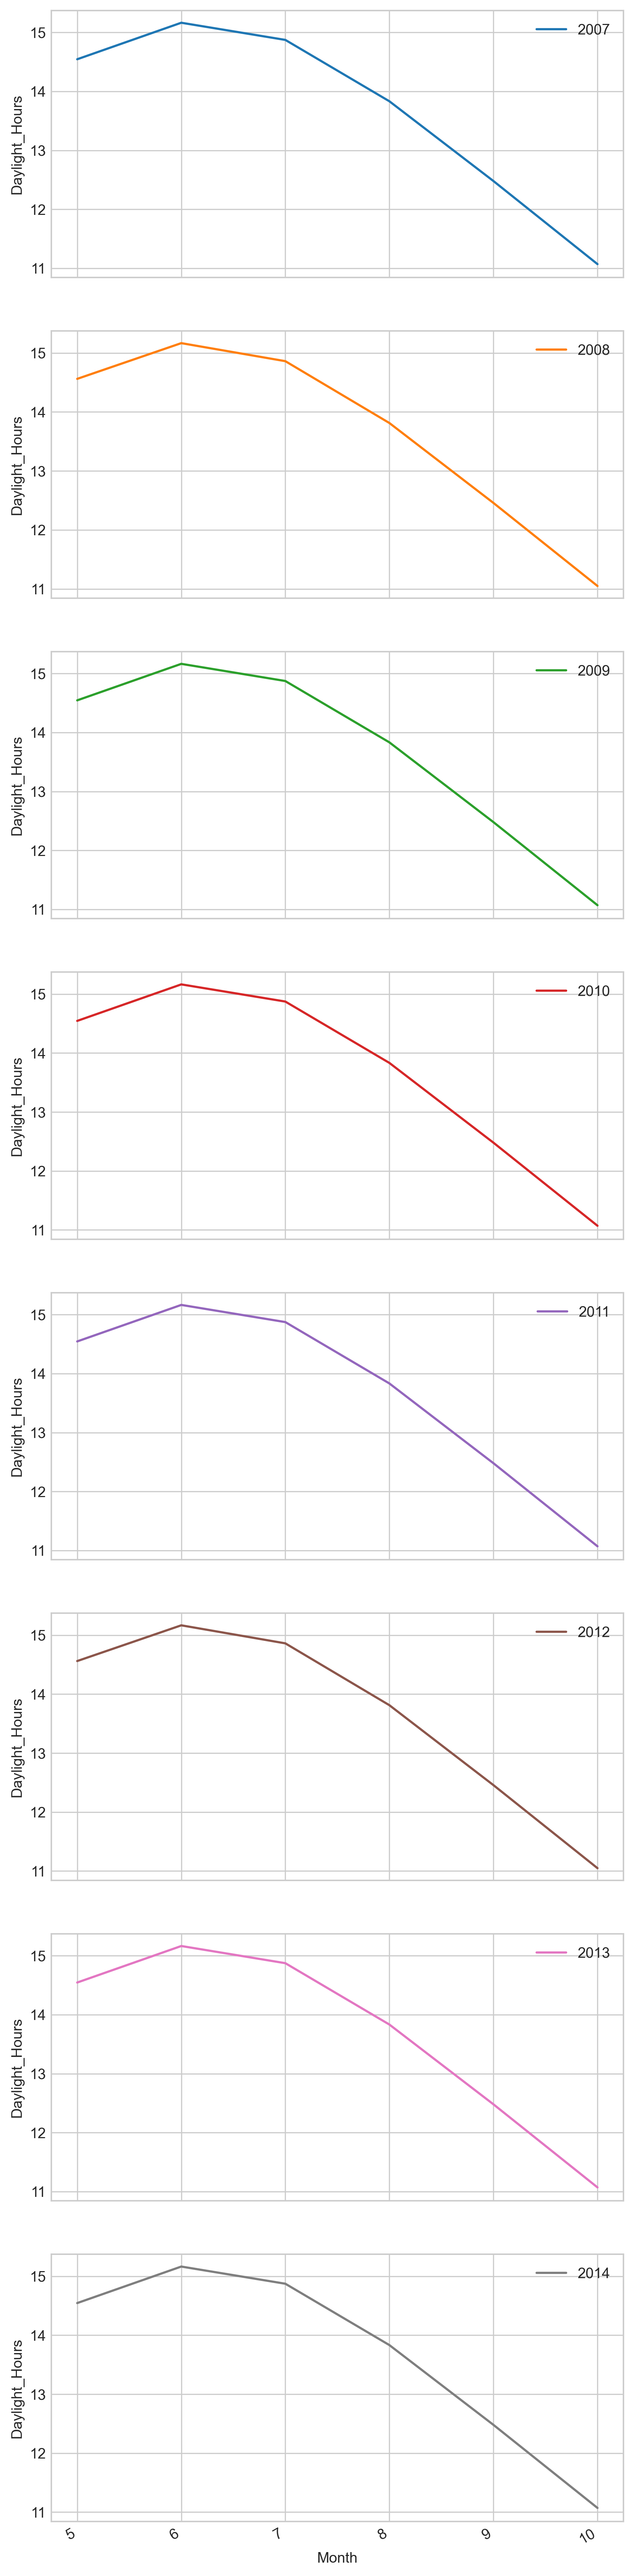

In [43]:
# Line plot visualization for mean Daylight_Hours values in each month for a given year
subplot_line('Daylight_Hours')

#### Observations

- It seems that for every year from 2007-2014, we have higher relative daylight hours for the months of May and June, peaking in June, followed by a gradual decrease in the ensuing months after June.

### CodeSums

In [44]:
# Filtering/Masking out categories with < 1% missing values and storing as variable
weather['CodeSum'].value_counts(normalize = True)[weather['CodeSum'].value_counts(normalize = True) > 0.01]
cs_cat_percent = weather['CodeSum'].value_counts(normalize = True)[weather['CodeSum'].value_counts(normalize = True) > 0.01]
cs_cat_percent = cs_cat_percent.sort_values(ascending = False) * 100
cs_cat_percent
# Click ... below to see output

              54.653533
RA            10.054348
RA BR          8.084239
BR             3.736413
TSRA RA BR     3.125000
BR HZ          2.751359
RA DZ BR       2.207880
TSRA RA        1.460598
HZ             1.324728
RA BR HZ       1.290761
TSRA           1.154891
Name: CodeSum, dtype: float64

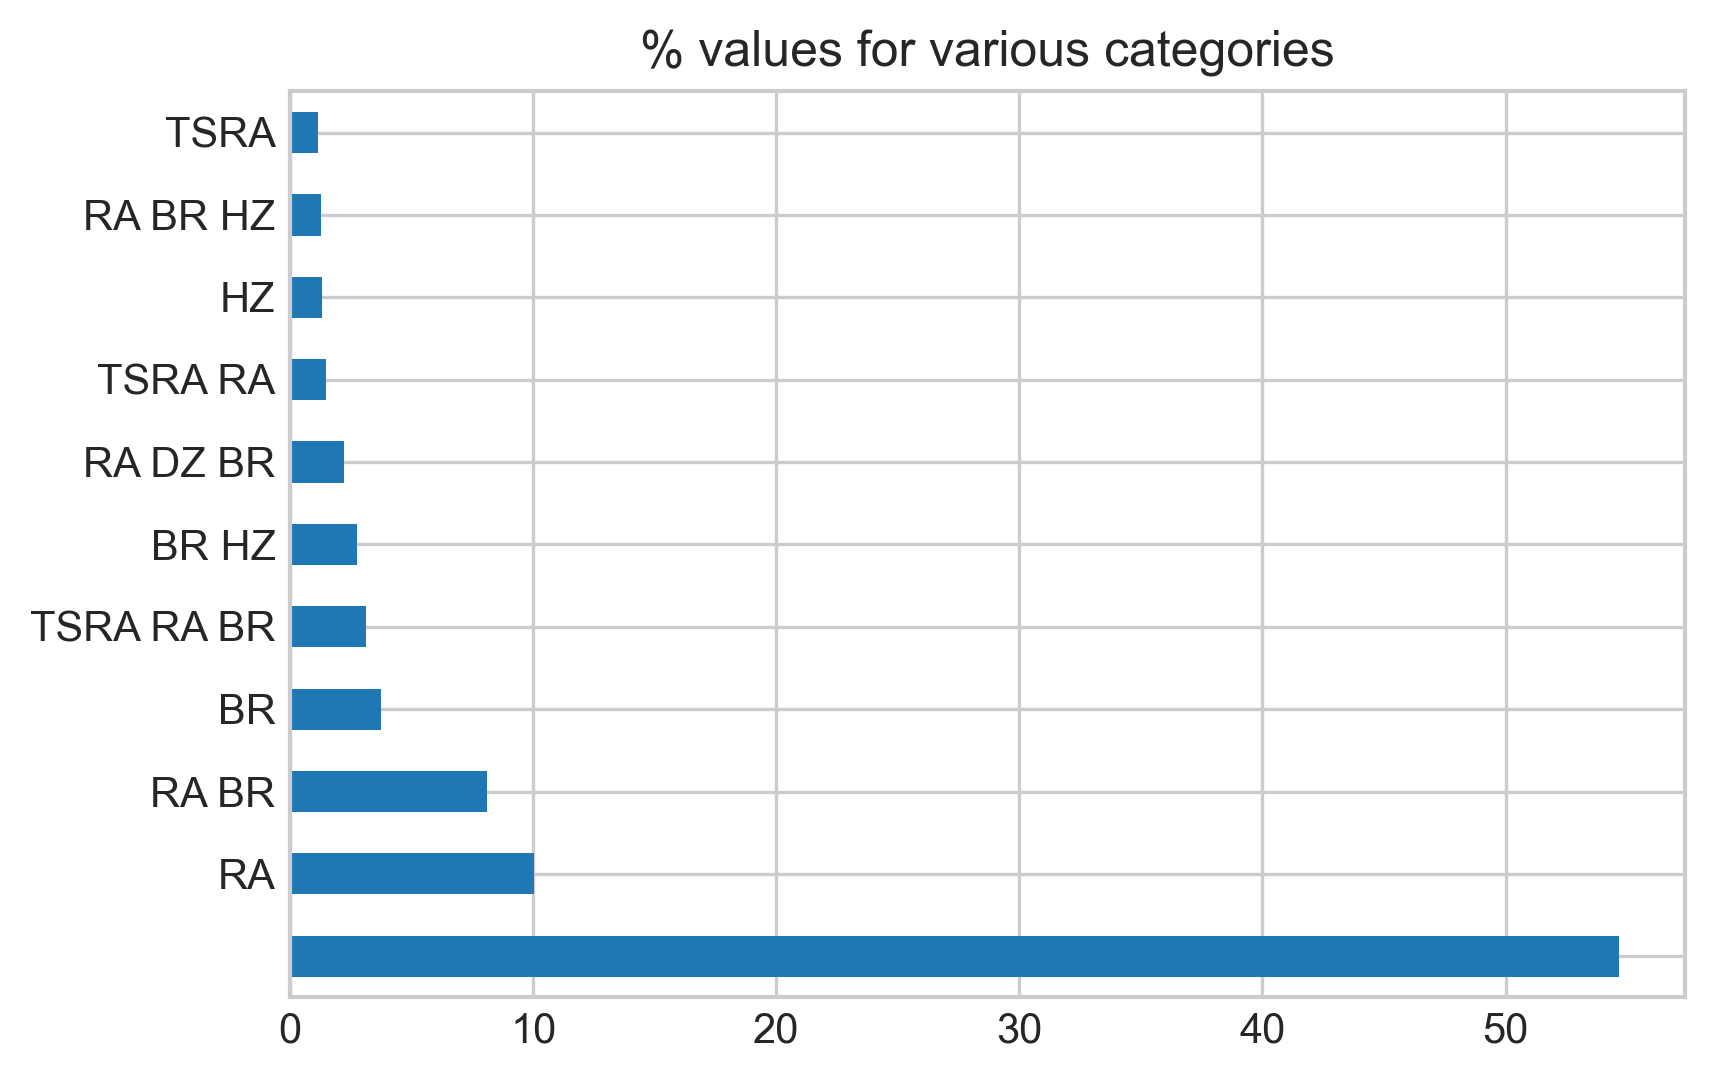

In [45]:
# Barplot for value percentages of all entries
cs_cat_percent.plot(kind = 'barh',title = '% values for various categories');

#### Observations
- We have more than 50% values which are ' ', signifying normal weather conditions. 
- There are over 30 different CodeSums for different conditions, with many of the combinations having RA (Rain) co-occuring across categories, which is not useful to have many categories to mean the same thing.
- It might make more sense to remap/ group the categories in this column into (Wet : 1 / Non-Wet : 0) conditions to better amplify the signal and filter out the noise.

In [46]:
# Creating list containing Codesums, decribing wet weather
code_sums = []
wet_codes = ['RA', 'TS', 'DZ', 'BR', 'UP', 'SH']

for code in weather['CodeSum']:
    code.replace('+', ' ')
    code_row = code.split()
    check_wet = 0
    for val in code_row:
        val_2 = None
        if len(val) > 2:
            val_1 = val[:2]
            val_2 = val[2:]
        else:
            val_1 = val
        
        if val_1 in wet_codes or val_2 in wet_codes:
            check_wet = 1

    code_sums.append(check_wet)

# Replace CodeSum column
weather['CodeSum'] = code_sums
weather.rename(columns={'CodeSum': 'Wet_NoWet'}, inplace=True)

In [47]:
weather['Wet_NoWet'].value_counts(normalize = True)

0    0.560802
1    0.439198
Name: Wet_NoWet, dtype: float64

We now have a more balanced representation of wet weather conditions against non-wet weather conditions, it should also be more easily understood by our model implemented later on.

## Correlation between variables in dataset

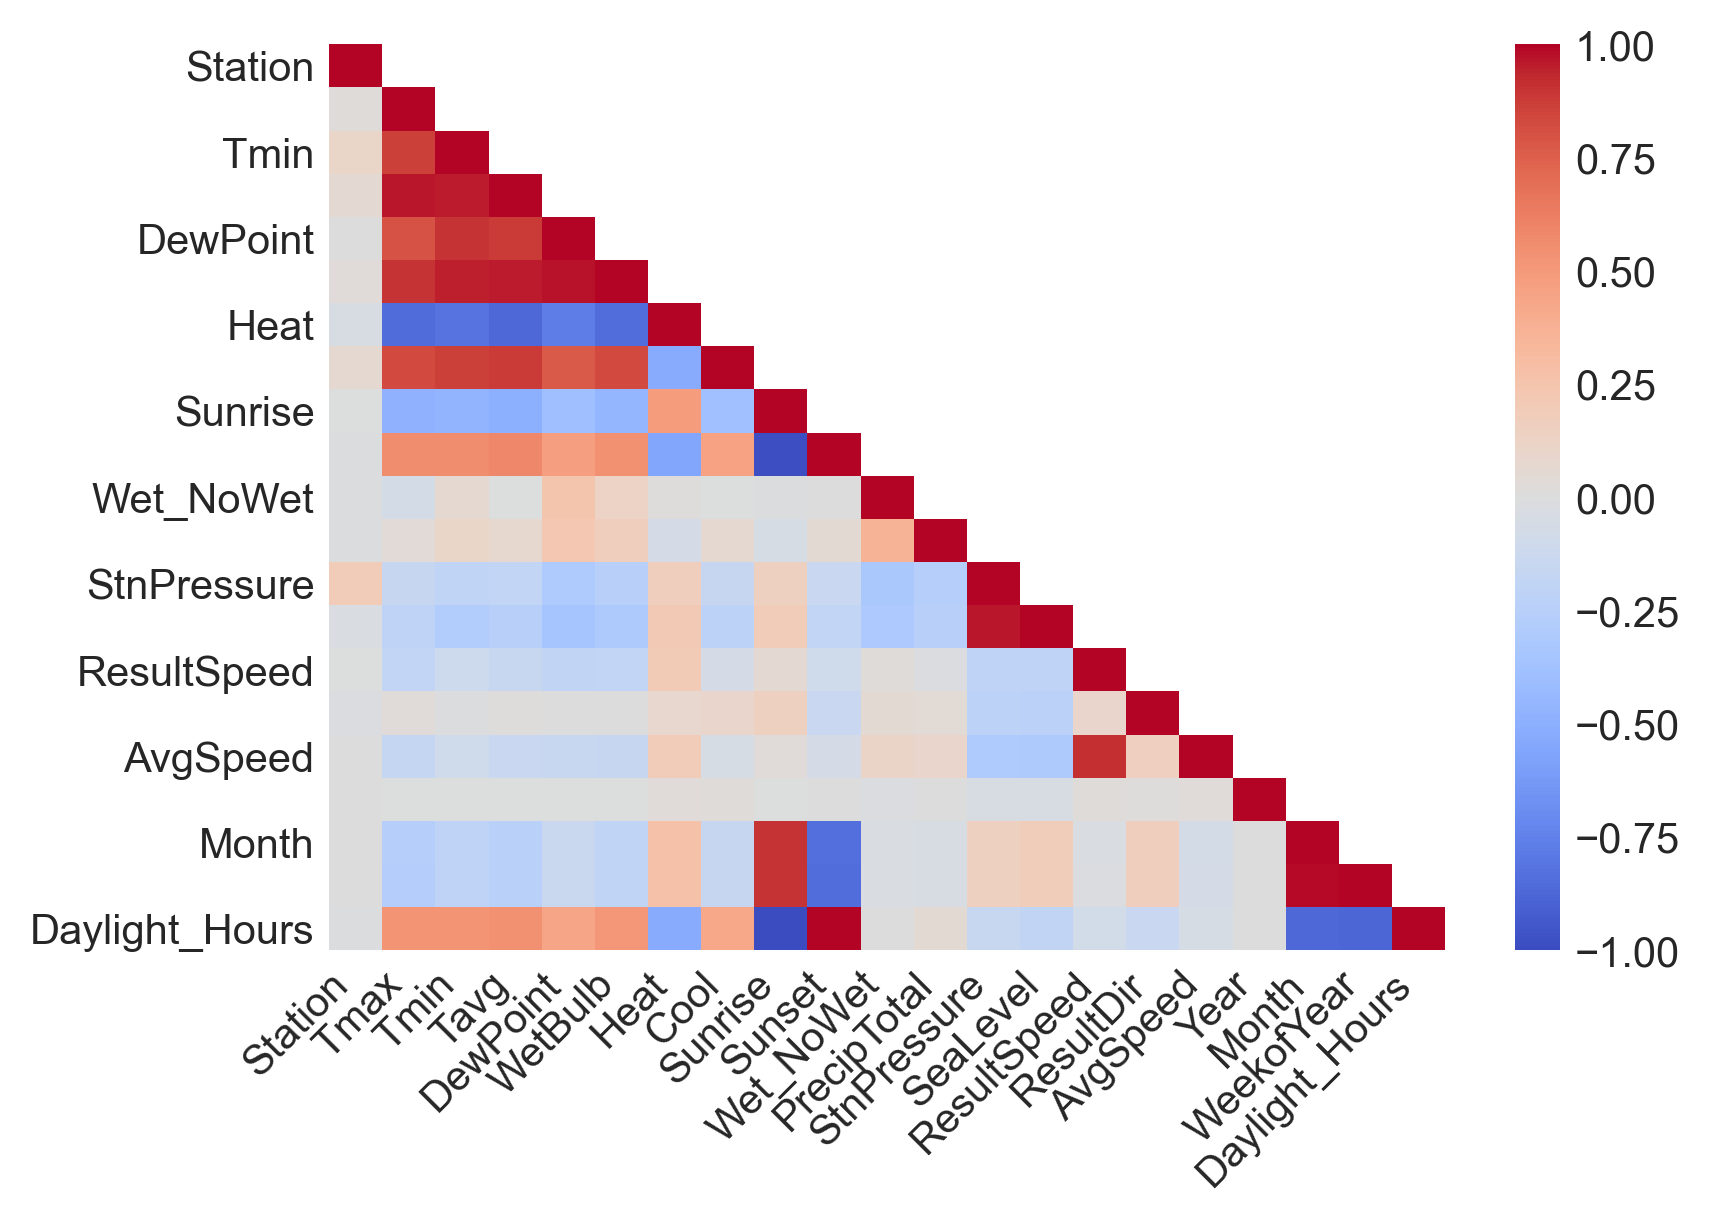

In [48]:
# Plotting Variables against one another in a correlation heatmap 
corr = weather.corr(method = 'pearson')
np.tril(np.ones(corr.shape)).astype('bool')[0:5,0:5] # Creating mask for upper triangle
df_lt = corr.where(np.tril(np.ones(corr.shape)).astype('bool')) # Applying mask for upper triangle
hmap=sns.heatmap(df_lt,vmin=-1,vmax=1,cmap='coolwarm') # using masked corr.df to plot 'half' heatmap
hmap.set_xticklabels(hmap.get_xticklabels(), rotation=45, horizontalalignment='right');

In [49]:
# Top 15 correlated variables
s = corr.abs().unstack()
so = s[s.sort_values(ascending = False) != 1]
so.sort_values(ascending = False).head(15)
# Click ... to see output

Daylight_Hours  Sunset            0.997224
Sunset          Daylight_Hours    0.997224
Sunrise         Daylight_Hours    0.995329
Daylight_Hours  Sunrise           0.995329
Sunset          Sunrise           0.985378
Sunrise         Sunset            0.985378
WeekofYear      Month             0.984700
Month           WeekofYear        0.984700
DewPoint        WetBulb           0.972341
WetBulb         DewPoint          0.972341
Tmax            Tavg              0.967861
Tavg            Tmax              0.967861
SeaLevel        StnPressure       0.967305
StnPressure     SeaLevel          0.967305
Tavg            WetBulb           0.960877
dtype: float64

### Observations
- We may want to explore feature reduction to eliminate some of these variables as there seems to be some overlapping relationships which may confuse the model if we use all of them. This will be explored further in feature selection as part of the pre-processing steps prior to modelling.

### Time-lag Features

Considering in our earlier EDA, we discovered some semblance of seasonality in some of the variables, which indicate that values logged at time (t) may very likely be affected by previous values (t-1,t-2...). As data in the `train` dataset is recorded at a weekly frequency, we will create time-lag features for 4 weeks, allowing us to capture the monthly trends. Before doing so, we should create weekly rolling averages for some of these features as 

In [50]:
# Initial creation of time-lag features based on selected subset of variables, with reference to correlation matrix
cols_to_roll_mean = ['Tavg','WetBulb','AvgSpeed','Daylight_Hours']
rollmean_col_creator(weather, cols_to_roll_mean, 7)

In [51]:
cols_to_time_lag = ['Weekly_Tavg','Weekly_WetBulb','Weekly_AvgSpeed','Weekly_Daylight_Hours']
timelag_col_creator(weather, cols_to_time_lag, 4)

In [52]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Station                     2944 non-null   int64         
 1   Date                        2944 non-null   datetime64[ns]
 2   Tmax                        2944 non-null   int64         
 3   Tmin                        2944 non-null   int64         
 4   Tavg                        2944 non-null   float64       
 5   DewPoint                    2944 non-null   int64         
 6   WetBulb                     2944 non-null   float64       
 7   Heat                        2944 non-null   float64       
 8   Cool                        2944 non-null   float64       
 9   Sunrise                     2944 non-null   float64       
 10  Sunset                      2944 non-null   float64       
 11  Wet_NoWet                   2944 non-null   int64       

In [53]:
# Save cleaned dataset as a csv file
weather.to_csv('weather_clean.csv', index=False)

In [54]:
weather['Sunset']

0       18.816667
1       18.816667
2       18.833333
3       18.833333
4       18.850000
5       18.850000
6       18.866667
7       18.866667
8       18.883333
9       18.883333
10      18.916667
11      18.900000
12      18.933333
13      18.916667
14      18.950000
15      18.933333
16      18.966667
17      18.966667
18      18.983333
19      18.983333
20      18.983333
21      19.000000
22      19.016667
23      19.016667
24      19.033333
25      19.033333
26      19.050000
27      19.050000
28      19.066667
29      19.066667
30      19.083333
31      19.083333
32      19.100000
33      19.100000
34      19.116667
35      19.116667
36      19.133333
37      19.133333
38      19.150000
39      19.150000
40      19.166667
41      19.166667
42      19.183333
43      19.183333
44      19.200000
45      19.183333
46      19.216667
47      19.200000
48      19.233333
49      19.216667
50      19.250000
51      19.233333
52      19.266667
53      19.250000
54      19.266667
55      19

# **Worth exploring if time permits**  

-Split weather dataset into sub datasets with columns from each of the stations to train model, in order to find out the impact of dropped 50% columns on prediction

In [ ]:
weather.columns

With some inputs provided by Zhen Ming over Slack relating to the two columns below, here are some things worth exploring to uncover deeper insights.

- Explore land/sea breeze/urban heat-island effects on the general direction differences in the day vs at night.

- Explore transformations to perform on ResultDir or separate columns ( to reflect the correct "directions" the values ought to represent and with a polarity modifier (+/-) to indicate the land/sea breeze phenomenon. ( Interation with sunlight hours may provide an idea of the proportionality of land vs sea breeze in a given day.

- Given that lake breezes are carried across large bodies of water, Lake Michigan has a very high tendency to carry more moisture, bringing about more water vapor molecules in the atmosphere. 

- Periods (months) with higher dew points equate to higher condensation rates as the air is more "saturated". When the air temperature drops below its dew point, excess moisture will be released in the form of condensation (might be a "hidden" factor, as these condensed water spots might become prime breeding grounds for mozzies) and are hard to take into account.

### ResultSpeed

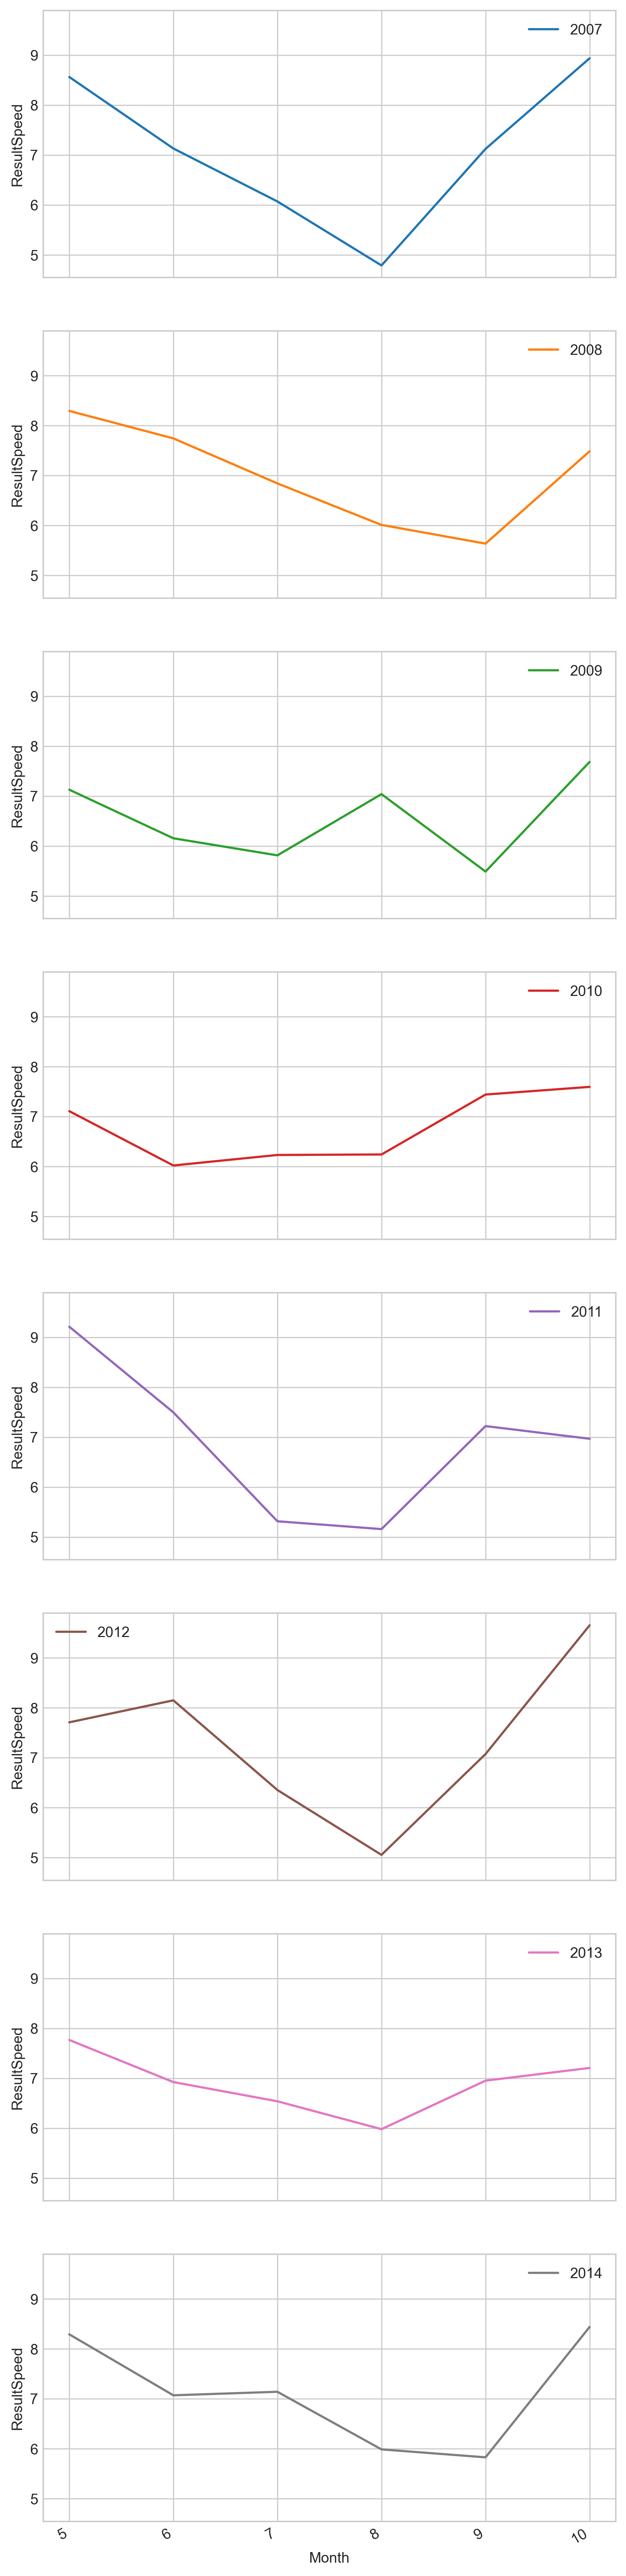

In [55]:
# Line plot visualization for mean ResultDir values in each month for a given year
subplot_line('ResultSpeed')

In [56]:
weather.ResultSpeed.unique()

array([ 1.7,  2.7, 13. , 13.3, 11.7, 12.9, 10.4, 10.1, 11.2, 14.4, 13.8,
        8.6,  8.5,  2.5,  3.9,  0.7,  2. , 11.3, 12.4, 12.7,  6.6,  6.4,
       16.9, 14.1,  8.1,  7.8,  8. , 10.5,  5.4,  3.4, 11.1,  6.3, 10. ,
       11.4, 10.9, 14.9,  4.9,  4.5,  2.8,  8.9,  8.2,  4.8,  4.7,  5.8,
       10.3,  9.7,  9.3,  4.2,  6.5,  7.5,  5.2,  7.9,  6.2, 10.8,  9.6,
       22.7, 20.3,  0.3,  2.4,  4.6,  8.3,  9.4,  7.2,  7. ,  5.6,  5.9,
        4.1,  3.8,  2.1,  4. , 14. , 12.2, 10.7,  3.5,  3.7,  7.6,  7.3,
        6.1, 11.9,  7.4,  5.1,  9.5,  6.7,  3.1,  4.3,  3.2,  3.3,  8.4,
       12.6,  8.8,  9.1,  1.4,  1.2,  4.4,  7.7,  1.9,  2.9,  1.1,  3. ,
       10.6,  5.5,  5.7,  1.6,  2.6,  1.5,  6.9,  3.6,  6. ,  0.5,  5.3,
        9. ,  2.2, 12.8,  9.2, 12.1,  1.8,  7.1,  6.8, 12.5,  5. ,  9.8,
        2.3, 11.5, 15.1, 14.6, 17.2, 15.5, 16.2, 17.7, 18. , 16.7, 16. ,
       13.9, 14.5, 10.2, 14.3, 13.7, 19.2, 13.2, 21.1, 11.8, 16.1, 14.8,
        8.7, 11.6, 13.6,  1. , 12. , 17.5, 13.4,  9

### ResultDir

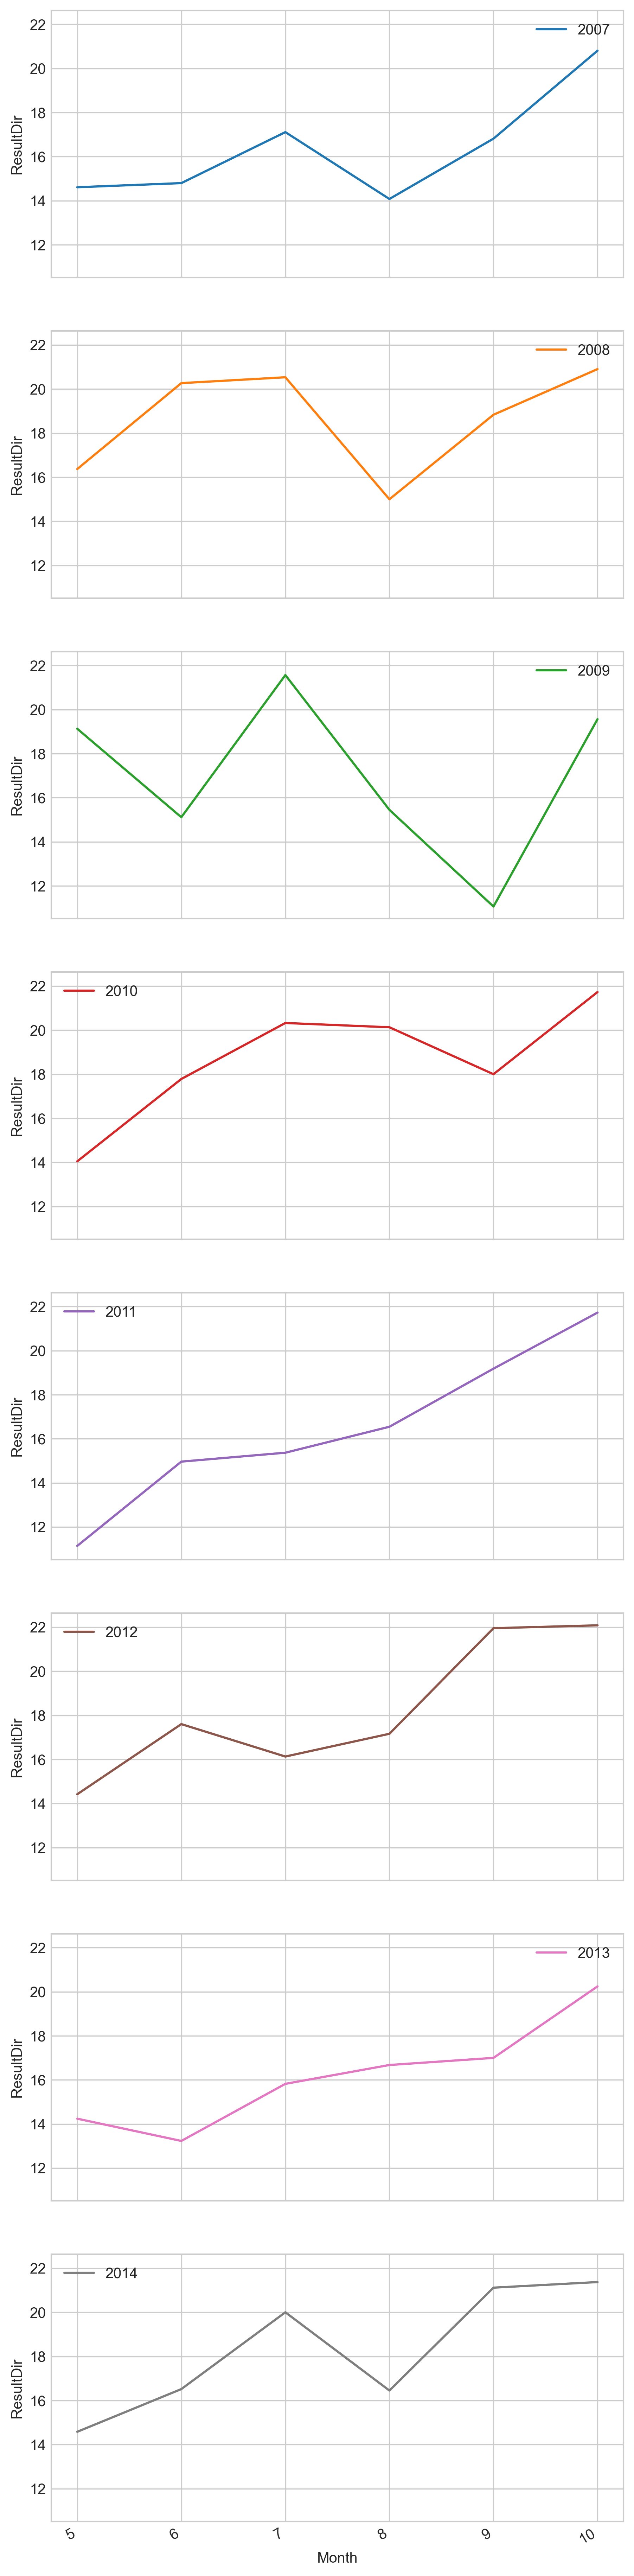

In [57]:
# Line plot visualization for mean ResultDir values in each month for a given year
subplot_line('ResultDir')

In [58]:
weather.ResultDir.unique()

array([27, 25,  4,  2,  7,  6,  8, 11, 10, 18, 17,  9,  3, 36,  1, 14, 21,
       22, 24, 23, 16, 19, 20,  5, 15, 26, 31, 30, 28, 33, 29, 12, 13, 32,
       35, 34], dtype=int64)